In [1]:
# !pip install optuna
# !pip install phik
# !pip install imblearn
# !pip install skorch

# Телеком. Отток клиентов.

**Содержание:**  
1. [Загрузка данных](#section_1)  
 1.1. [Импорт библиотек](#section_1_1)  
 1.2. [Загрузка данных](#section_1_2)  
    
    
2. [Анализ данных](#section_2)  
 2.1. [Анализ исходных датафреймов](#section_2_1)  
 2.2. [Анализ объединенного датафрейма](#section_2_2)  
 2.3. [Подготовка данных](#section_2_3)  
 
 
3. [Обучение моделей](#section_3)  
 3.1. [Модель RandomForestClassifier](#section_3_1)  
 3.2. [Модель CatBoostClassifier](#section_3_2)  
 3.3. [NeuralNetClassifier](#section_3_3)  


4. [Проверка на тестовой выборке](#section_4)  


5. [Общий вывод](#section_5)  

**Заказчик исследования:** Оператор связи "ТелеДом".  
**Цель исследования:** построить модель прогнозирования оттока клиентов.  
**Описание услуг оператора связи:**  
Оператор предоставляет два основных типа услуг:  
- Стационарную телефонную связь. Телефон можно подключить к нескольким линиям одновременно.  
- Интернет. Подключение бывает двух типов: через телефонную линию DSL (англ. digital subscriber line — «цифровая абонентская линия») или оптоволоконный кабель (англ. fiber optic).
Также абонентам доступен ряд услуг:
- Интернет-безопасность: антивирус (Device Protection) и блокировка опасных сайтов (Online Security);
- Выделенная линия технической поддержки (Tech Support);
- Облачное хранилище файлов для резервного копирования данных (Online Backup);
- Стриминговое телевидение (Streaming TV) и каталог фильмов (Streaming Movies).
За услуги клиенты могут платить ежемесячно или раз в 1–2 года. Доступны различные способы расчёта и возможность получить электронный чек.

**Требования:** Значение метрики ROC-AUC не должна быть менее 0,85 на тестовой выборке.  


**Исходные данные:**  
Исходные данные представлены в датасетах:
1. contract — информация о договорах;
 - customerID — ID абонента;
 - BeginDate — дата начала действия договора;
 - EndDate — дата окончания действия договора;
 - Type — тип оплаты: раз в год-два или ежемесячно;
 - PaperlessBilling — электронный расчётный лист;
 - PaymentMethod — тип платежа;
 - MonthlyCharges — расходы за месяц;
 - TotalCharges — общие расходы абонента.  
 
2. personal - персональные данные клиентов;  
 - customerID — ID пользователя;
 - gender — пол;
 - SeniorCitizen — является ли абонент пенсионером;
 - Partner — есть ли у абонента супруг или супруга;
 - Dependents — есть ли у абонента дети.  
 
3. internet - информация об интернет-услугах.
 - customerID — ID пользователя;
 - InternetService — тип подключения;
 - OnlineSecurity — блокировка опасных сайтов;
 - OnlineBackup — облачное хранилище файлов для резервного копирования данных;
 - DeviceProtection — антивирус;
 - TechSupport — выделенная линия технической поддержки;
 - StreamingTV — стриминговое телевидение;
 - StreamingMovies — каталог фильмов.

4. phone - информация об услугах телефонии.
 - customerID — ID пользователя;
 - MultipleLines — подключение телефона к нескольким линиям одновременно.

## Загрузка данных
<a id="section_1"></a>

### Импорт библиотек
<a id="section_1_1"></a>

In [2]:
import datetime
import numpy as np
import optuna
import pandas as pd
import matplotlib.pyplot as plt
import phik
import seaborn as sns
import timeit
import torch
import torch.nn as nn

from catboost import CatBoostClassifier
from imblearn.pipeline import Pipeline, make_pipeline
from optuna.integration import OptunaSearchCV
from optuna.distributions import CategoricalDistribution as ctd
from optuna.distributions import FloatDistribution as floatd
from optuna.distributions import IntDistribution as intd
from phik.report import plot_correlation_matrix
from sklearn import datasets
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import f1_score, precision_recall_curve, recall_score, roc_auc_score, roc_curve
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold, train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.utils.class_weight import compute_class_weight
from skorch import NeuralNetClassifier
from skorch.callbacks import EarlyStopping
from sqlalchemy import create_engine

### Загрузка данных
<a id="section_1_2"></a>

In [3]:
db_config = {
    'user': 'praktikum_student',# имя пользователя,
    'pwd': 'Sdf4$2;d-d30pp',# пароль,
    'host': 'rc1b-wcoijxj3yxfsf3fs.mdb.yandexcloud.net',
    'port': 6432,# порт подключения,
    'db': 'data-science-final'# название базы данных,
}

connection_string = 'postgresql://{}:{}@{}:{}/{}'.format(
    db_config['user'],
    db_config['pwd'],
    db_config['host'],
    db_config['port'],
    db_config['db'],
)

In [4]:
engine = create_engine(connection_string) 

In [5]:
def column_name(df, columns_dict):
    
    '''функция преобразования названий признаков'''
    
    df.columns = map(str.lower, df.columns)                       # приводим в нижний регистр
    df = df.rename(columns = columns_dict)                        # переименовываем
    return df

Загружаем информацию о договорах:

In [6]:
query = '''
SELECT *
FROM telecom.contract;
'''

df_contract = pd.read_sql_query(query, con=engine)                         # словарь для переименования названий признаков
contract_columns = {'customerid' : 'customer_id',
                   'begindate' : 'begin_date',
                   'enddate' : 'end_date',
                   'paperlessbilling' : 'paper_less_billing',
                   'paymentmethod' : 'payment_method',
                   'monthlycharges' : 'monthly_charges',
                   'totalcharges' : 'total_charges'}
df_contract = column_name(df_contract, contract_columns)

Загружаем персональные данные клиентов:

In [7]:
query = '''
SELECT *
FROM telecom.personal;
'''

df_personal = pd.read_sql_query(query, con=engine)
personal_columns = {'customerid' : 'customer_id',                            # словарь для переименования названий признаков
                   'seniorcitizen' : 'senior_citizen'}
df_personal = column_name(df_personal, personal_columns)

Загружаем данные об интернет-услугах:

In [8]:
query = '''
SELECT *
FROM telecom.internet;
'''

df_internet = pd.read_sql_query(query, con=engine)                           # словарь для переименования названий признаков
df_internet.columns = df_internet.iloc[0]
internet_columns = {'customerid' : 'customer_id',
                   'internetservice' : 'internet_service',
                   'onlinesecurity' : 'online_security',
                   'onlinebackup' : 'online_backup',
                   'deviceprotection' : 'device_protection',
                   'techsupport' : 'tech_support',
                   'streamingtv' : 'streaming_tv',
                   'streamingmovies' : 'streaming_movies'}
df_internet = column_name(df_internet, internet_columns).drop(df_internet.index[0])

Загружаем данные по услугам телефонии:

In [9]:
query = '''
SELECT *
FROM telecom.phone;
'''

df_phone = pd.read_sql_query(query, con=engine)                               # словарь для переименования названий признаков
df_phone.columns = df_phone.iloc[0]
phone_columns = {'customerid' : 'customer_id',
                   'multiplelines' : 'multiple_lines'}
df_phone = column_name(df_phone, phone_columns).drop(df_phone.index[0])

## Анализ данных
<a id="section_2"></a>

### Анализ исходных датафреймов
<a id="section_2_1"></a>

Задаем значений random_state:

In [10]:
RS = 181023

Функция вывода общей информации по датафрейму:

In [11]:
def inf(df_info):
    
    '''функция получения общей информации'''
    
    print()
    print('Общая информация:')
    display(df_info.info(memory_usage='deep'))
    print('_' * 50)
    print()
    print('Описательная статистика строковых значений:')
    display(df_info.describe(include='object').T)
    print('_' * 50)
    print()
    print('Описательная статистика числовых значений:')
    display(df_info.describe().T)
    print('_' * 50)
    print()
    print('Процент пропущенных значений:')
    display(df_info.isna().mean()*100)
    print('_' * 50)
    print()
    print('Процент дубликатов по идентификатору абонента:')
    print(100 * (df_info['customer_id'].count() - df_info['customer_id'].nunique()) / df_info['customer_id'].count())
    print('_' * 50)
    print()
    print('Случайная выборка датафрейма:')
    display(df_info.sample(n = 5, random_state = RS))
    print('_' * 100)

**Датафрейм df_contract**

In [12]:
inf(df_contract)


Общая информация:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   customer_id         7043 non-null   object 
 1   begin_date          7043 non-null   object 
 2   end_date            1869 non-null   object 
 3   type                7043 non-null   object 
 4   paper_less_billing  7043 non-null   object 
 5   payment_method      7043 non-null   object 
 6   monthly_charges     7043 non-null   float64
 7   total_charges       7032 non-null   float64
dtypes: float64(2), object(6)
memory usage: 2.4 MB


None

__________________________________________________

Описательная статистика строковых значений:


,count,unique,top,freq
customer_id,7043,7043,3249-ZPQRG,1
begin_date,7043,515,2019-03-13,43
end_date,1869,4,2019-11-01,485
type,7043,3,Month-to-month,3875
paper_less_billing,7043,2,Yes,4171
payment_method,7043,4,Electronic check,2365


__________________________________________________

Описательная статистика числовых значений:


,count,mean,std,min,25%,50%,75%,max
monthly_charges,7043.0,64.761692,30.090047,18.25,35.50,70.350,89.8500,118.75
total_charges,7032.0,2283.300441,2266.771362,18.80,401.45,1397.475,3794.7375,8684.80


__________________________________________________

Процент пропущенных значений:


customer_id            0.000000
begin_date             0.000000
end_date              73.463013
type                   0.000000
paper_less_billing     0.000000
payment_method         0.000000
monthly_charges        0.000000
total_charges          0.156183
dtype: float64

__________________________________________________

Процент дубликатов по идентификатору абонента:
0.0
__________________________________________________

Случайная выборка датафрейма:


,customer_id,begin_date,end_date,type,paper_less_billing,payment_method,monthly_charges,total_charges
4521,2560-QTSBS,2019-05-30,None,One year,Yes,Bank transfer (automatic),23.30,1623.15
3280,3638-VBZTA,2019-01-17,None,Two year,Yes,Bank transfer (automatic),86.50,5882.75
2561,0297-RBCSG,2019-04-27,None,One year,Yes,Bank transfer (automatic),65.35,1231.85
6446,6434-TTGJP,2019-06-02,None,Two year,No,Credit card (automatic),53.70,521.00
4664,8800-JOOCF,2019-02-15,None,Month-to-month,Yes,Electronic check,84.05,966.55


____________________________________________________________________________________________________


В датафрейме 7043 строк. Присутствуют пропуски в данных по дате окончания договора (73%) и в данных по общим расходам (0,15%).  
В датафрейме 4 уникальных даты окончания договора.  
Дубликаты по идентификационному номеру абонента отсутствуют.

Распределение абонентов по типу подписки:

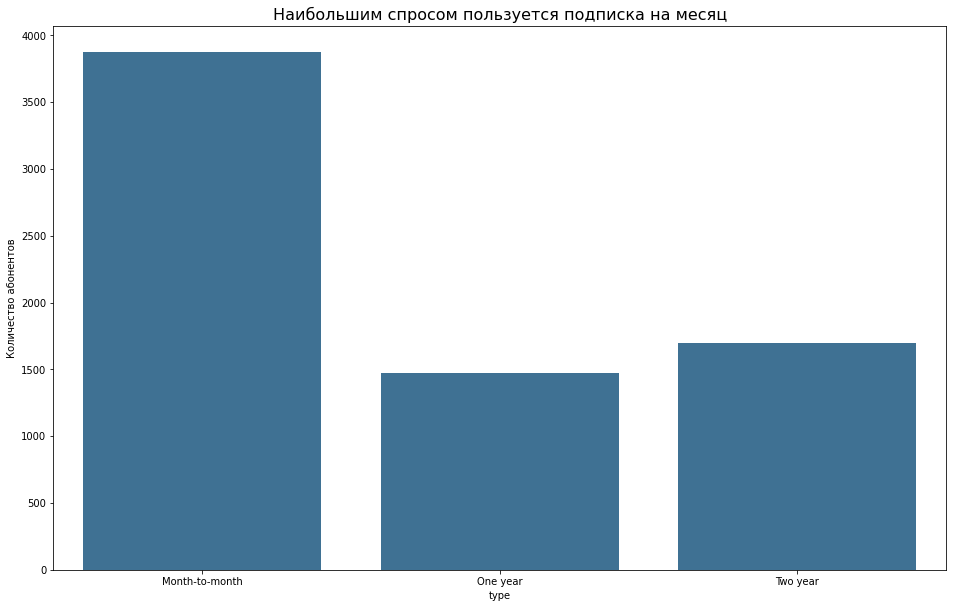

In [13]:
fig = plt.figure(figsize=(16,10))
ax = sns.barplot(x='type',
                 y='customer_id',
                 data=(
                     df_contract
                     .groupby(['type'])['customer_id']
                     .count()
                     .reset_index()
                 ),
                 color='#3174a1'
            )
plt.title('Наибольшим спросом пользуется подписка на месяц', fontsize=16)
plt.ylabel('Количество абонентов')
plt.xlabel('type')
plt.xticks(rotation=0)
plt.show()

Наибольшим спросом пользуется подписка на месяц

Распределение абонентов по признакам paper_less_billing (электронный расчётный лист) и payment_method (тип платежа):

In [14]:
def separation_category_visualization(df, feature):
    
    '''функция визуализации распределения категориальных значений'''
    
    fig = plt.figure(figsize=(16,10))
    ax = sns.barplot(x=i,
                     y='customer_id',
                     hue='type',
                     data=(
                         df
                         .groupby([i, 'type'])['customer_id']
                         .count()
                         .reset_index())
                    )
    plt.title('Распределение по признаку {} с учетом типа подписки'.format(feature), fontsize=16)
    plt.ylabel('Количество абонентов')
    plt.xlabel(i)
    plt.xticks(rotation=0)
    plt.show()

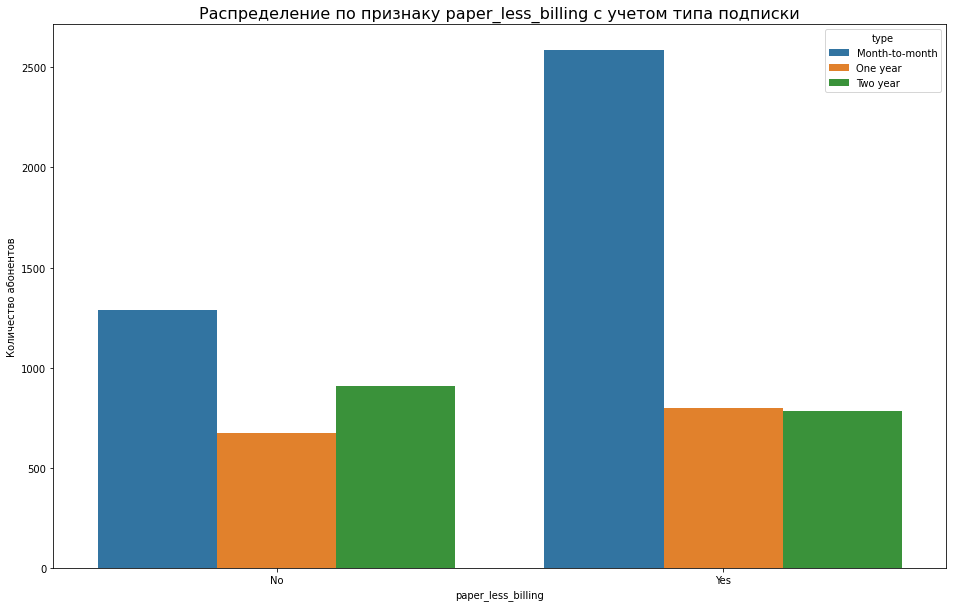

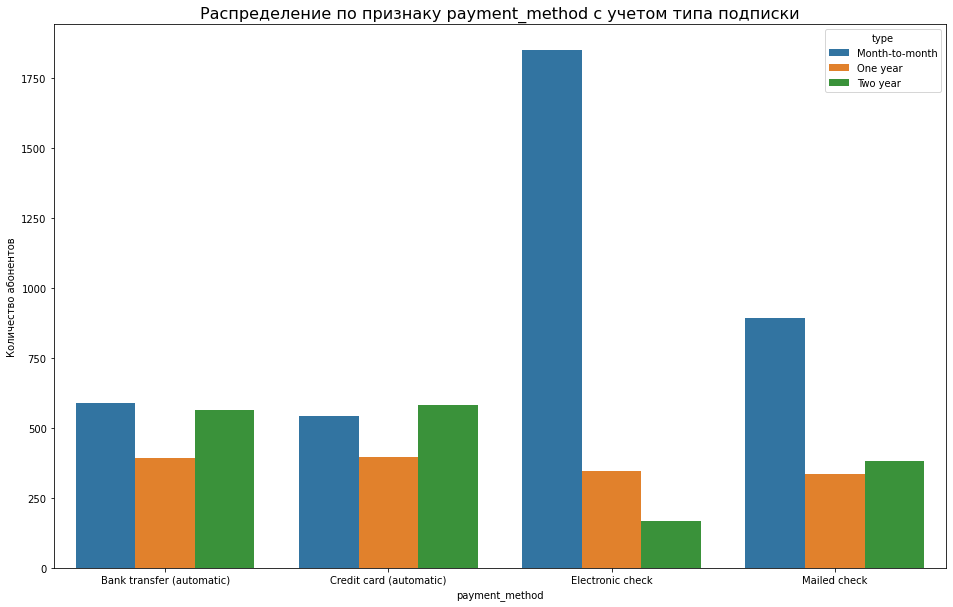

In [15]:
for i in ['paper_less_billing', 'payment_method']:
    separation_category_visualization(df_contract, i)

Чаще электронный расчётный лист используется абонентами, имеющими подписку на месяц.  
Самый популярный метод расчёта - Electronic check, в основном, за счет абонентов, имеющих подписку на месяц.

Диаграммы размаха и распределения абонентов по суммам расходов:

In [16]:
def charges_visualization(df, abonents):
    fig = plt.figure(figsize=(20, 20))
    
    ax1 = fig.add_subplot(2, 2, 1)
    ax1 = sns.boxplot(df['monthly_charges'])
    ax1 = plt.title('Диаграмма размаха расходов за месяц', fontsize=16)
    ax1 = plt.xlabel('Расходы за месяц')

    ax2 = fig.add_subplot(2, 2, 2)
    ax2 = df['monthly_charges'].hist(bins=int((df['monthly_charges'].max() - df['monthly_charges'].min()) // 5))
    ax2 = plt.title('Распределение расходов за месяц', fontsize=16)
    ax2 = plt.xlabel('Расходы за месяц')
    ax2 = plt.ylabel('Количество абонентов')

    ax3 = fig.add_subplot(2, 2, 3)
    ax3 = sns.boxplot(df['total_charges'])
    ax3 = plt.title('Диаграмма размаха общих расходов', fontsize=16)
    ax3 = plt.xlabel('Общие расходы')

    ax4 = fig.add_subplot(2, 2, 4)
    ax4 = df['total_charges'].hist(bins=int((df['total_charges'].max() - df['total_charges'].min()) // 100))
    ax4 = plt.title('Распределение общих расходов', fontsize=16)
    ax4 = plt.xlabel('Общие расходы')
    
    fig.suptitle('По данным для {} абонентов'.format(abonents), fontsize=30)

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


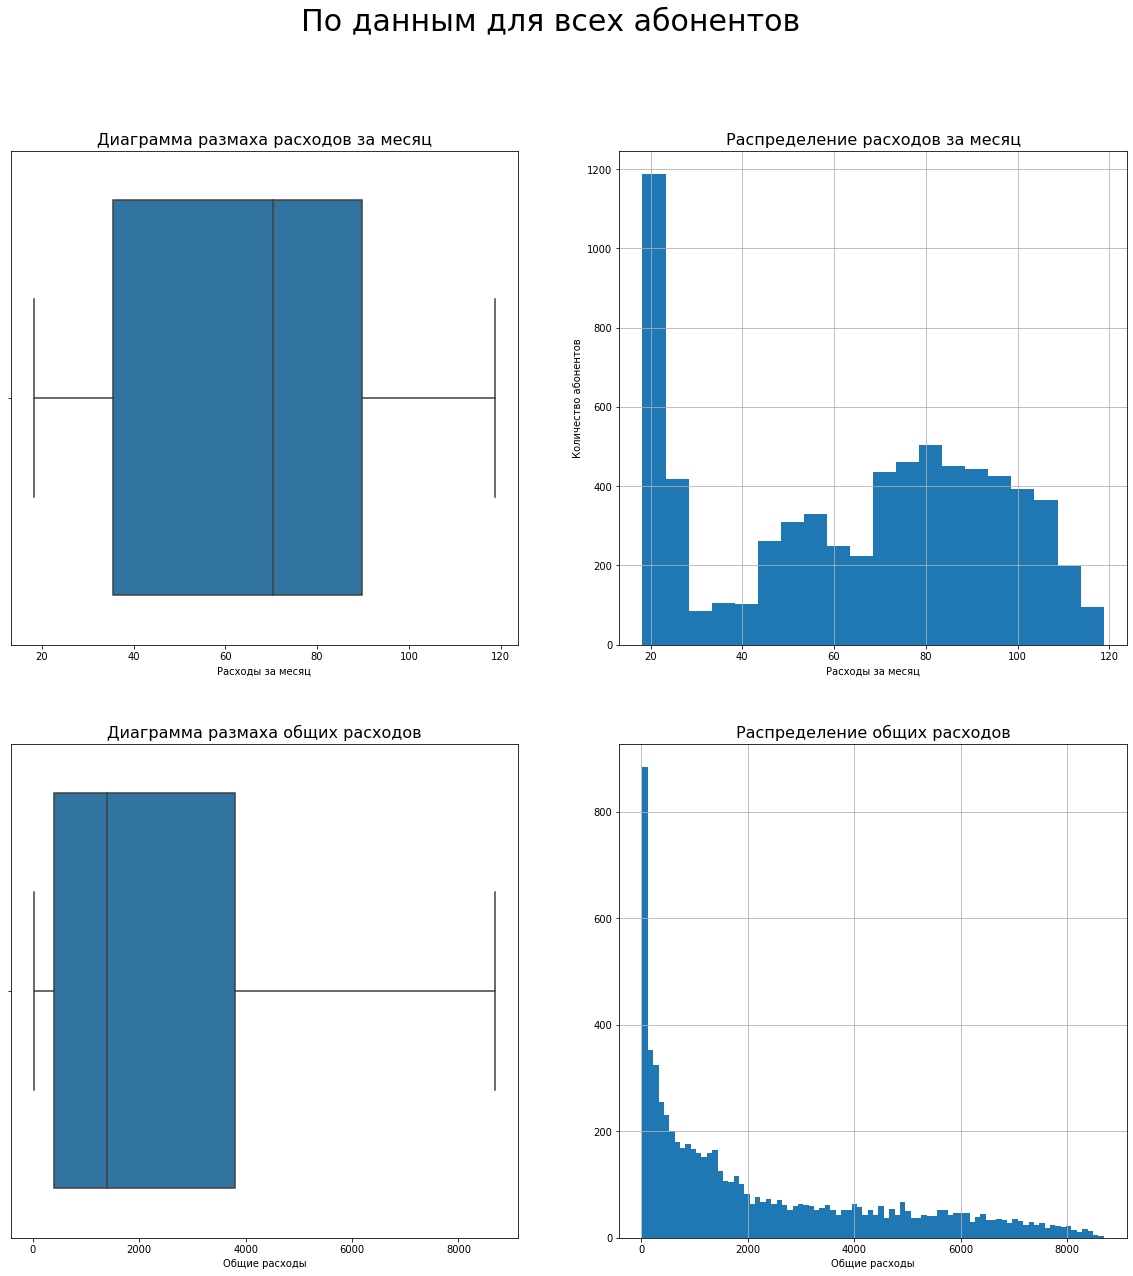

In [17]:
charges_visualization(df_contract, 'всех')

Аномальные значения по ежемесячным и общим расходам отсутствуют.

**Датафрейм df_personal**

In [18]:
inf(df_personal)


Общая информация:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   customer_id     7043 non-null   object
 1   gender          7043 non-null   object
 2   senior_citizen  7043 non-null   int64 
 3   partner         7043 non-null   object
 4   dependents      7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 1.7 MB


None

__________________________________________________

Описательная статистика строковых значений:


,count,unique,top,freq
customer_id,7043,7043,3249-ZPQRG,1
gender,7043,2,Male,3555
partner,7043,2,No,3641
dependents,7043,2,No,4933


__________________________________________________

Описательная статистика числовых значений:


,count,mean,std,min,25%,50%,75%,max
senior_citizen,7043.0,0.162147,0.368612,0.0,0.0,0.0,0.0,1.0


__________________________________________________

Процент пропущенных значений:


customer_id       0.0
gender            0.0
senior_citizen    0.0
partner           0.0
dependents        0.0
dtype: float64

__________________________________________________

Процент дубликатов по идентификатору абонента:
0.0
__________________________________________________

Случайная выборка датафрейма:


,customer_id,gender,senior_citizen,partner,dependents
4521,8671-KKKOS,Female,0,Yes,No
3280,6504-VBLFL,Male,0,Yes,No
2561,3230-JCNZS,Female,0,Yes,Yes
6446,2205-LPVGL,Male,1,Yes,Yes
4664,7571-YXDAD,Female,0,No,No


____________________________________________________________________________________________________


В датафрейме 7043 строк.  
Пропущенных значений нет.  
Все признаки, кроме идентификатора абонента - бинарные.

Распределения категориальных признаков:

In [19]:
def category_visualization(df, feature):
    fig = plt.figure(figsize=(16,10))
    ax = sns.barplot(x=i,
                     y='customer_id',
                     data=(
                         df
                         .groupby([i])['customer_id']
                         .count()
                         .sort_values()
                         .reset_index()
                     ),
                     color='#3174a1'
                    )
    plt.title('Распределения признака {}'.format(feature), fontsize=16)
    plt.ylabel('Количество абонентов')
    plt.xlabel(i)
    plt.xticks(rotation=0)
    plt.show()

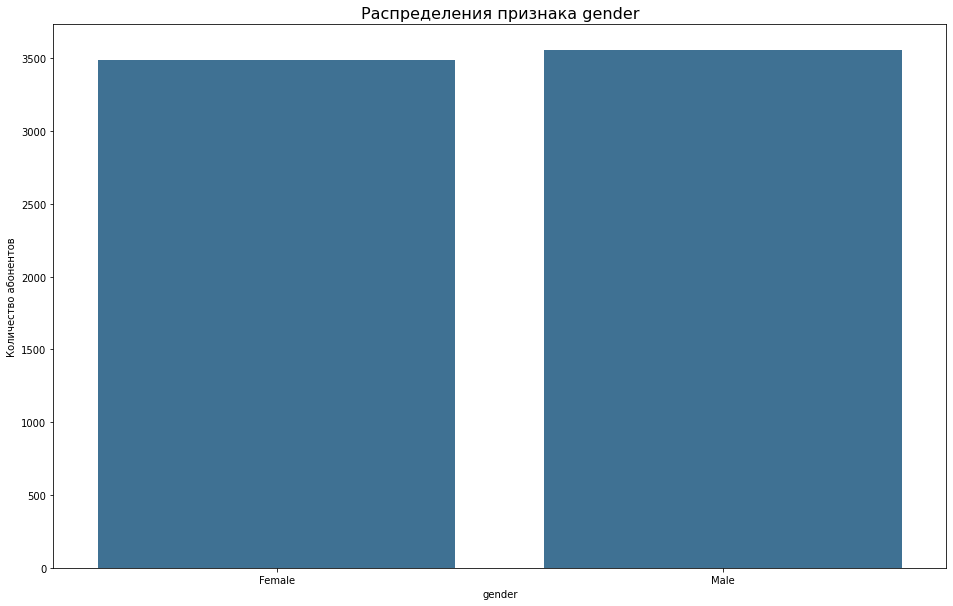

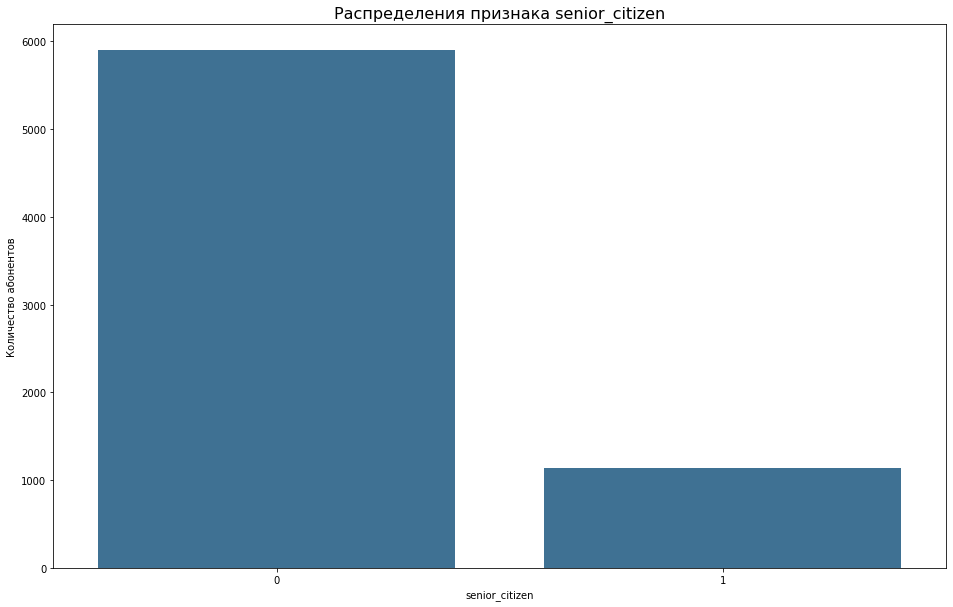

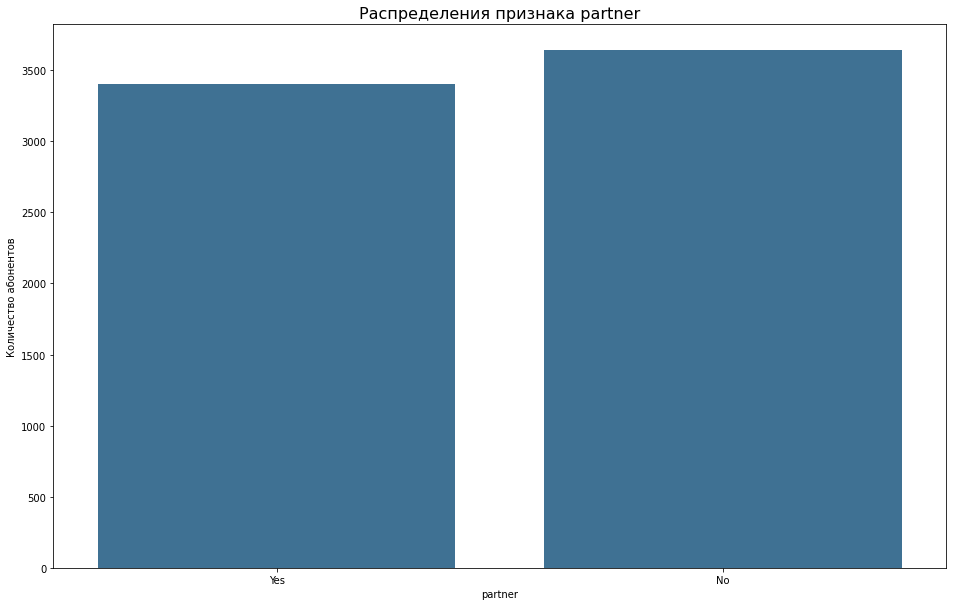

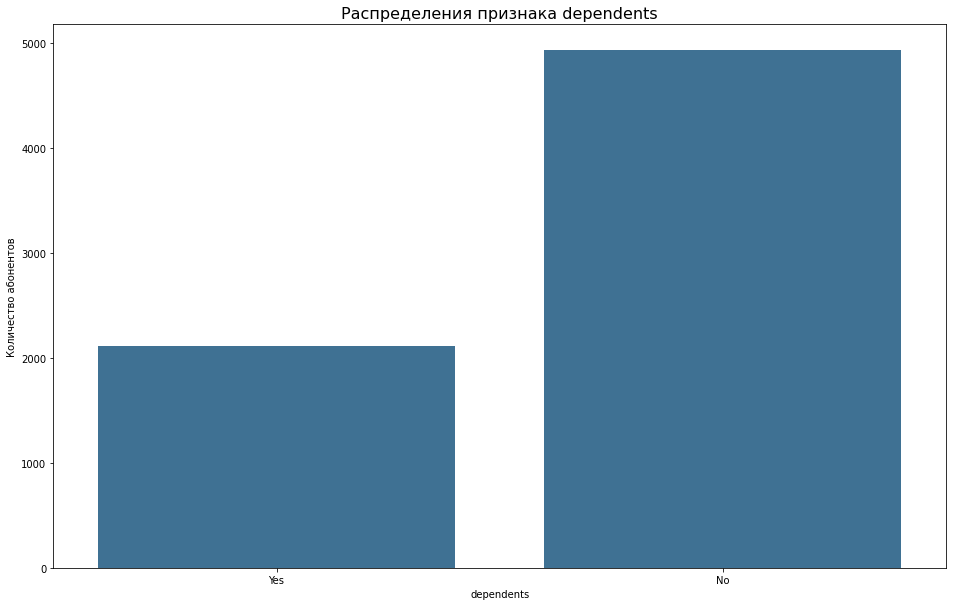

In [20]:
for i in df_personal.drop(['customer_id'], axis=1).columns:
    category_visualization(df_personal, i)

В выборке не дисбаланса по признаку пола (gender) и наличия супруга или супруги (partner).  
Количество пенсионеров в 6 раз меньше, чем не пенсионеров.  
Количество абонентов с детьми в 2,5 меньше, чем бездетных.

**Датафрейм df_internet**

In [21]:
inf(df_internet)


Общая информация:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 5517 entries, 1 to 5517
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   customer_id        5517 non-null   object
 1   internet_service   5517 non-null   object
 2   online_security    5517 non-null   object
 3   online_backup      5517 non-null   object
 4   device_protection  5517 non-null   object
 5   tech_support       5517 non-null   object
 6   streaming_tv       5517 non-null   object
 7   streaming_movies   5517 non-null   object
dtypes: object(8)
memory usage: 2.6 MB


None

__________________________________________________

Описательная статистика строковых значений:


,count,unique,top,freq
customer_id,5517,5517,3249-ZPQRG,1
internet_service,5517,2,Fiber optic,3096
online_security,5517,2,No,3498
online_backup,5517,2,No,3088
device_protection,5517,2,No,3095
tech_support,5517,2,No,3473
streaming_tv,5517,2,No,2810
streaming_movies,5517,2,No,2785


__________________________________________________

Описательная статистика числовых значений:


,count,unique,top,freq
customer_id,5517,5517,3249-ZPQRG,1
internet_service,5517,2,Fiber optic,3096
online_security,5517,2,No,3498
online_backup,5517,2,No,3088
device_protection,5517,2,No,3095
tech_support,5517,2,No,3473
streaming_tv,5517,2,No,2810
streaming_movies,5517,2,No,2785


__________________________________________________

Процент пропущенных значений:


customer_id          0.0
internet_service     0.0
online_security      0.0
online_backup        0.0
device_protection    0.0
tech_support         0.0
streaming_tv         0.0
streaming_movies     0.0
dtype: float64

__________________________________________________

Процент дубликатов по идентификатору абонента:
0.0
__________________________________________________

Случайная выборка датафрейма:


,customer_id,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies
5019,9746-YKGXB,DSL,Yes,No,Yes,No,No,Yes
3082,8945-GRKHX,Fiber optic,No,No,No,No,No,Yes
1340,0375-HVGXO,DSL,No,No,No,No,Yes,No
3936,9927-DSWDF,Fiber optic,Yes,Yes,No,Yes,Yes,Yes
1780,2506-CLAKW,Fiber optic,Yes,Yes,Yes,Yes,No,Yes


____________________________________________________________________________________________________


В датафрейме 5517 строк.  
Пропущенных значений нет.  
Все признаки, кроме идентификатора абонента - бинарные.

Распределения категориальных признаков:

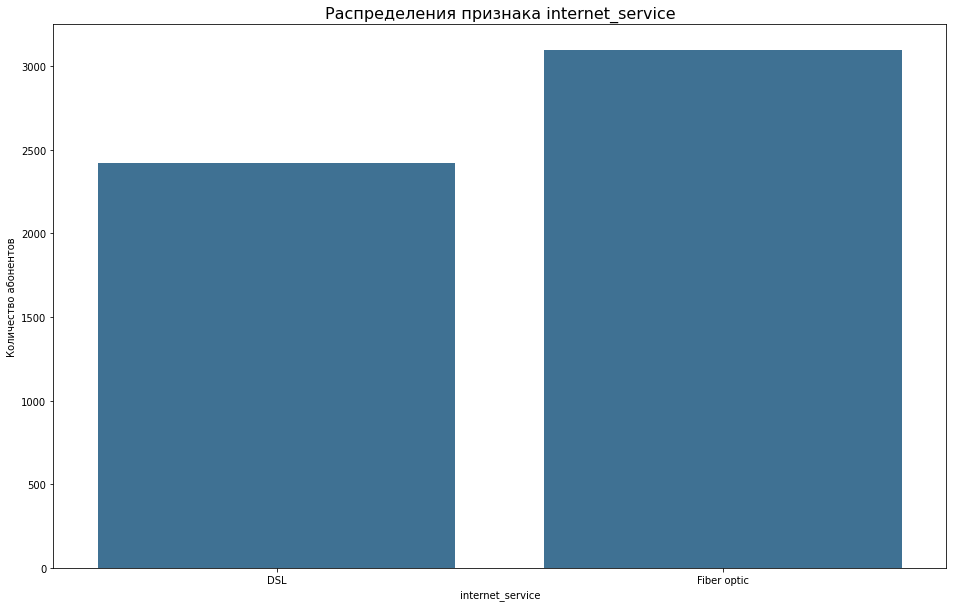

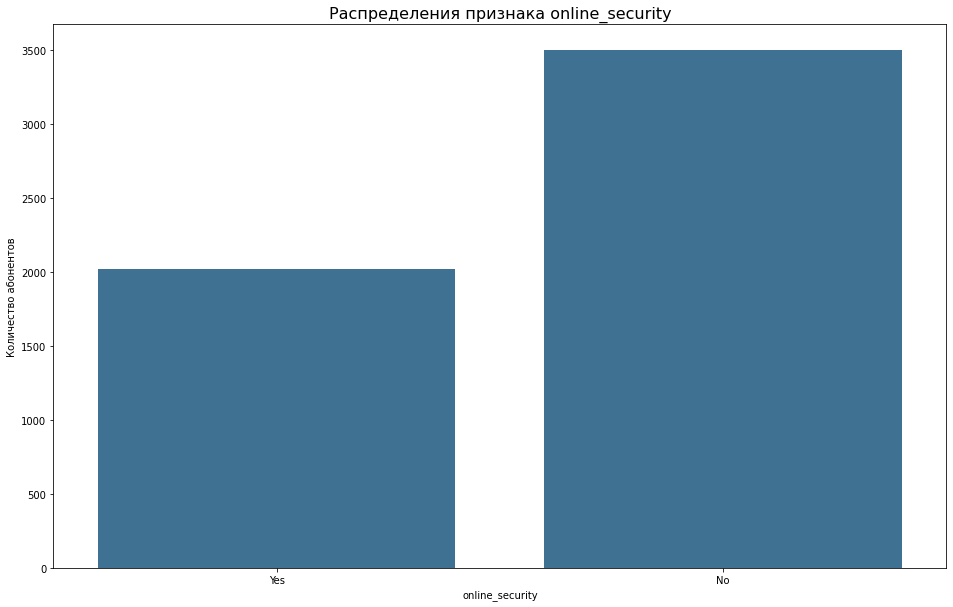

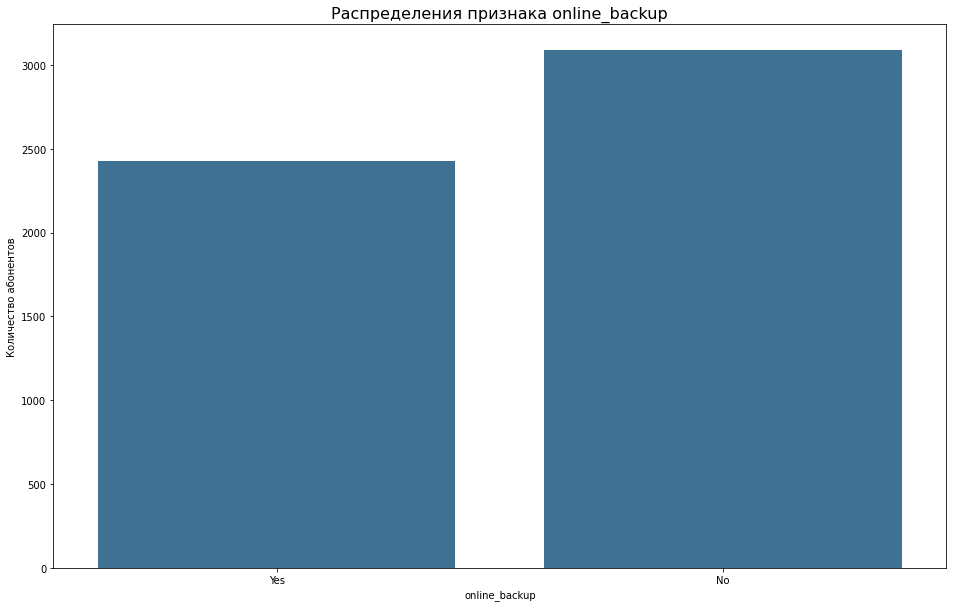

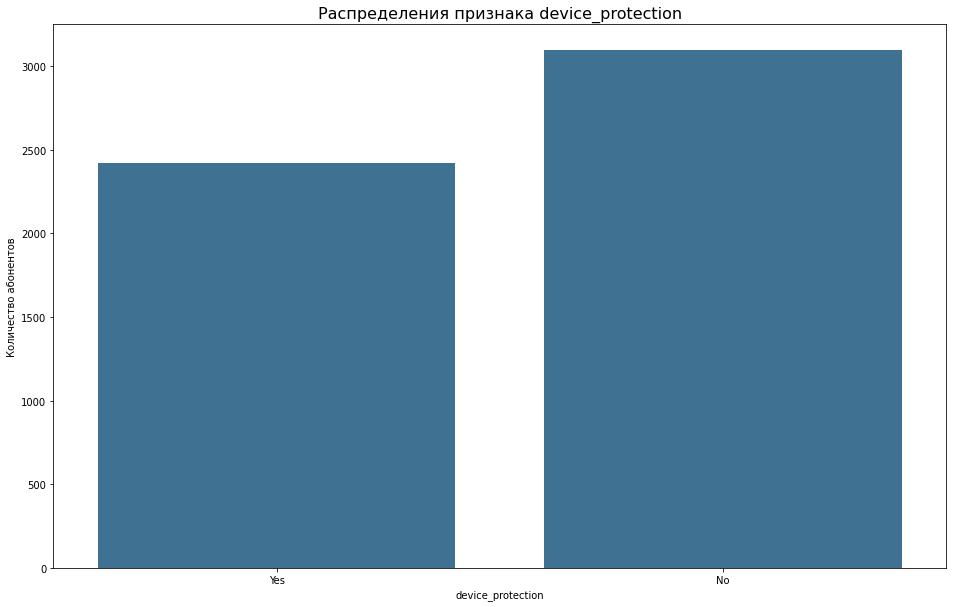

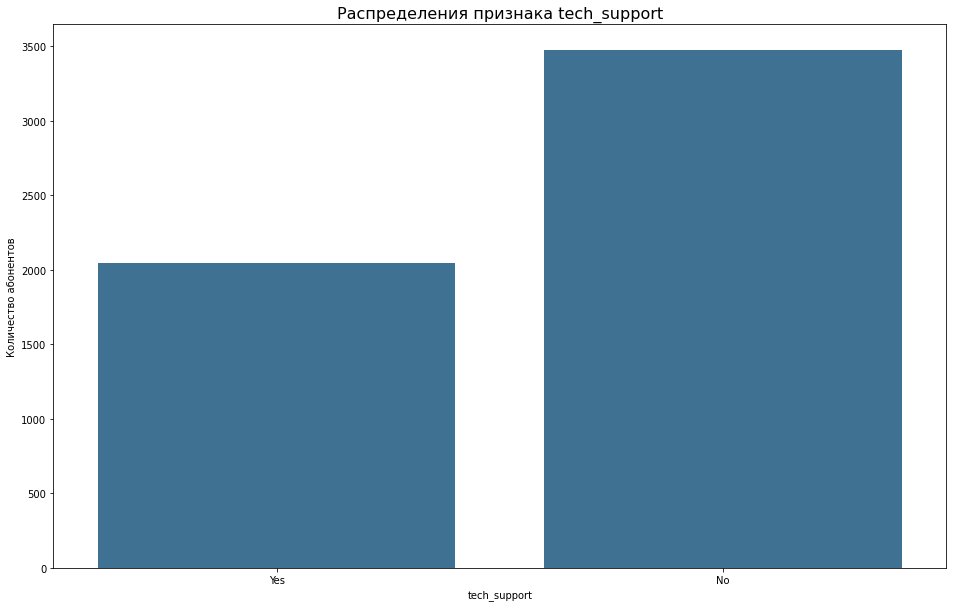

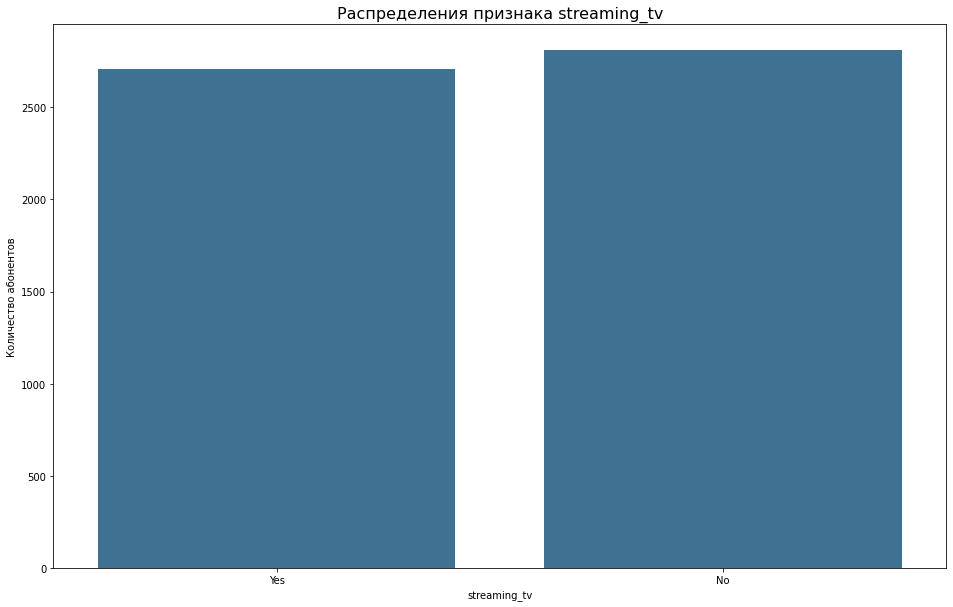

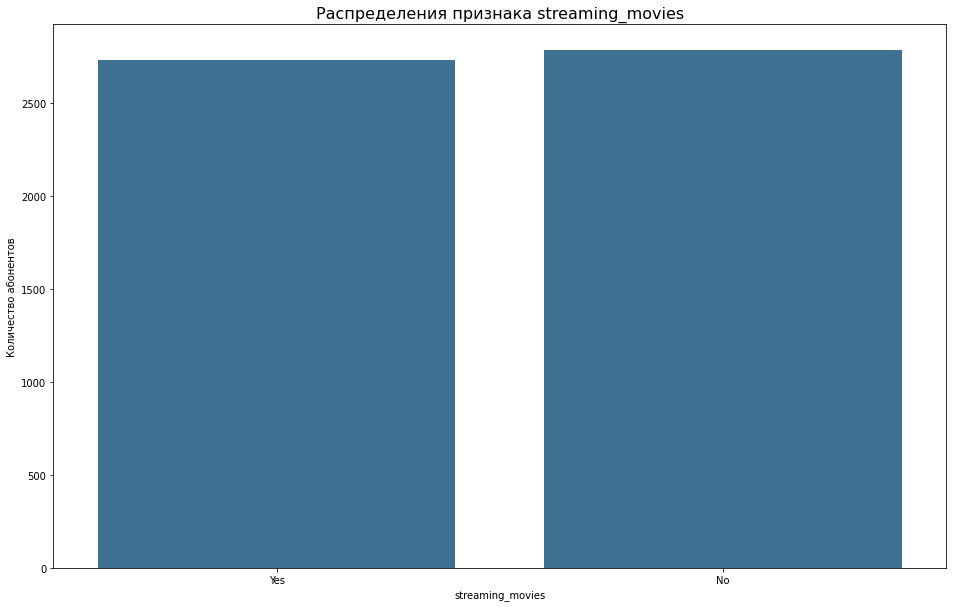

In [22]:
for i in df_internet.drop(['customer_id'], axis=1).columns:
    category_visualization(df_internet, i)

**Датафрейм df_phone**

In [23]:
inf(df_phone)


Общая информация:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 6361 entries, 1 to 6361
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   customer_id     6361 non-null   object
 1   multiple_lines  6361 non-null   object
dtypes: object(2)
memory usage: 835.3 KB


None

__________________________________________________

Описательная статистика строковых значений:


,count,unique,top,freq
customer_id,6361,6361,3249-ZPQRG,1
multiple_lines,6361,2,No,3390


__________________________________________________

Описательная статистика числовых значений:


,count,unique,top,freq
customer_id,6361,6361,3249-ZPQRG,1
multiple_lines,6361,2,No,3390


__________________________________________________

Процент пропущенных значений:


customer_id       0.0
multiple_lines    0.0
dtype: float64

__________________________________________________

Процент дубликатов по идентификатору абонента:
0.0
__________________________________________________

Случайная выборка датафрейма:


,customer_id,multiple_lines
3977,2520-SGTTA,No
3695,3423-HHXAO,No
4717,0643-OKLRP,Yes
2809,5751-USDBL,No
32,6047-YHPVI,No


____________________________________________________________________________________________________


В датафрейме 6361 строк.  
Пропущенных значений нет.  
Признак multiple_lines - бинарный.  

Распределения признака multiple_lines (подключение телефона к нескольким линиям одновременно):

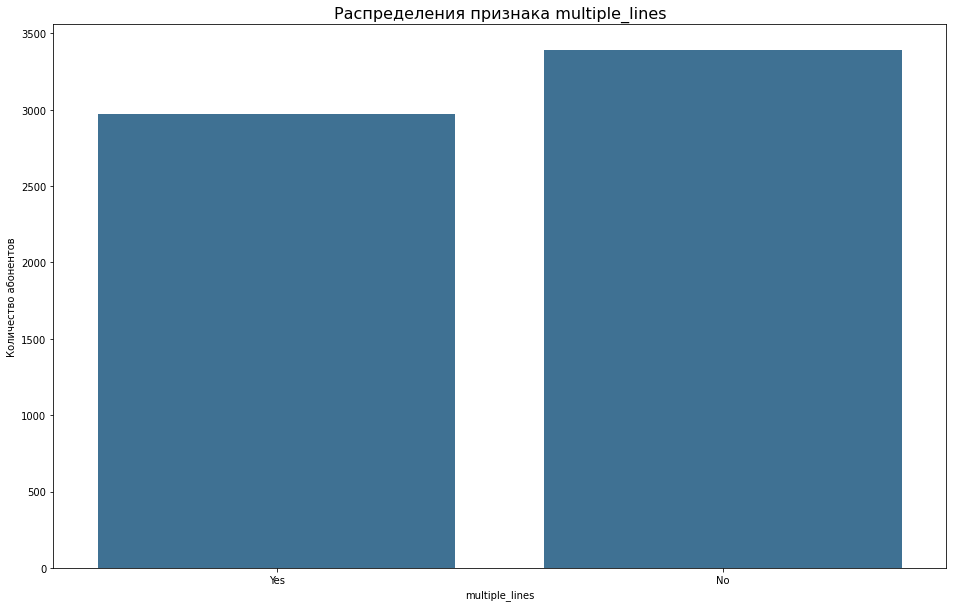

In [24]:
for i in df_phone.drop(['customer_id'], axis=1).columns:
    category_visualization(df_phone, i)

Ркзультаты анализа исходных данных.  
- df_contract:  
В датафрейме 7043 строк. Присутствуют пропуски в данных по дате окончания договора (73%) и в данных по общим расходам (0,15%).  
В датафрейме 4 уникальных даты окончания договора.  
Дубликаты по идентификационному номеру абонента отсутствуют.  
Наибольшим спросом пользуется подписка на месяц.    
Чаще электронный расчётный лист используется абонентами, имеющими подписку на месяц.  
Самый популярный метод расчёта - Electronic check, в основном, за счет абонентов, имеющих подписку на месяц.  
Аномальные значения по ежемесячным и общим расходам отсутствуют.  

- df_personal:  
В датафрейме 7043 строк.  
Пропущенных значений нет.  
Все признаки, кроме идентификатора абонента - бинарные.  
В выборке не дисбаланса по признаку пола (gender) и наличия супруга или супруги (partner).  
Количество пенсионеров в 6 раз меньше, чем не пенсионеров.  
Количество абонентов с детьми в 2,5 меньше, чем бездетных.  

- df_internet:  
В датафрейме 5517 строк.  
Пропущенных значений нет.  
Все признаки, кроме идентификатора абонента - бинарные.  

- df_phone:  
В датафрейме 6361 строк.  
Пропущенных значений нет.  
Признак multiple_lines - бинарный. 

### Анализ объединенного датафрейма
<a id="section_2_2"></a>

**Объединение таблиц**

Наиболее полно абоненты представлены в датафреймах df_contract (информация по договорам) и df_personal (информация по абонентам). В остальных датафреймах данные по некоторым пользователям могут отсутствовать: не все пользуются услугами, информация о которых представлена в df_internet (данные по интернет-услугам) и df_phone (данные по услугам телефонии). Поэтому объединяем таблицы путем левого присоединения их к датафрейму df_contract по customer_id:

In [25]:
df = (df_contract
      .merge(df_personal, how='left', on='customer_id')                           # присоединяем датафрейм df_personal
      .merge(df_internet, how='left', on='customer_id')                           # присоединяем датафрейм df_internet
      .merge(df_phone, how='left', on='customer_id')                              # присоединяем датафрейм df_phone
     )

Выводим общую информацию ро объединенному датафрейму:

In [26]:
inf(df)


Общая информация:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   customer_id         7043 non-null   object 
 1   begin_date          7043 non-null   object 
 2   end_date            1869 non-null   object 
 3   type                7043 non-null   object 
 4   paper_less_billing  7043 non-null   object 
 5   payment_method      7043 non-null   object 
 6   monthly_charges     7043 non-null   float64
 7   total_charges       7032 non-null   float64
 8   gender              7043 non-null   object 
 9   senior_citizen      7043 non-null   int64  
 10  partner             7043 non-null   object 
 11  dependents          7043 non-null   object 
 12  internet_service    5517 non-null   object 
 13  online_security     5517 non-null   object 
 14  online_backup       5517 non-null   object 
 15  device_protection   5517 non-null   

None

__________________________________________________

Описательная статистика строковых значений:


,count,unique,top,freq
customer_id,7043,7043,3249-ZPQRG,1
begin_date,7043,515,2019-03-13,43
end_date,1869,4,2019-11-01,485
type,7043,3,Month-to-month,3875
paper_less_billing,7043,2,Yes,4171
payment_method,7043,4,Electronic check,2365
gender,7043,2,Male,3555
partner,7043,2,No,3641
dependents,7043,2,No,4933
internet_service,5517,2,Fiber optic,3096


__________________________________________________

Описательная статистика числовых значений:


,count,mean,std,min,25%,50%,75%,max
monthly_charges,7043.0,64.761692,30.090047,18.25,35.50,70.350,89.8500,118.75
total_charges,7032.0,2283.300441,2266.771362,18.80,401.45,1397.475,3794.7375,8684.80
senior_citizen,7043.0,0.162147,0.368612,0.00,0.00,0.000,0.0000,1.00


__________________________________________________

Процент пропущенных значений:


customer_id            0.000000
begin_date             0.000000
end_date              73.463013
type                   0.000000
paper_less_billing     0.000000
payment_method         0.000000
monthly_charges        0.000000
total_charges          0.156183
gender                 0.000000
senior_citizen         0.000000
partner                0.000000
dependents             0.000000
internet_service      21.666903
online_security       21.666903
online_backup         21.666903
device_protection     21.666903
tech_support          21.666903
streaming_tv          21.666903
streaming_movies      21.666903
multiple_lines         9.683374
dtype: float64

__________________________________________________

Процент дубликатов по идентификатору абонента:
0.0
__________________________________________________

Случайная выборка датафрейма:


,customer_id,begin_date,end_date,type,paper_less_billing,payment_method,monthly_charges,total_charges,gender,senior_citizen,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines
4521,2560-QTSBS,2019-05-30,None,One year,Yes,Bank transfer (automatic),23.30,1623.15,Female,0,Yes,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Yes
3280,3638-VBZTA,2019-01-17,None,Two year,Yes,Bank transfer (automatic),86.50,5882.75,Male,0,No,Yes,DSL,Yes,Yes,No,Yes,Yes,Yes,Yes
2561,0297-RBCSG,2019-04-27,None,One year,Yes,Bank transfer (automatic),65.35,1231.85,Male,0,No,No,DSL,No,Yes,No,Yes,No,Yes,No
6446,6434-TTGJP,2019-06-02,None,Two year,No,Credit card (automatic),53.70,521.00,Male,0,Yes,Yes,DSL,Yes,Yes,Yes,Yes,No,Yes,NaN
4664,8800-JOOCF,2019-02-15,None,Month-to-month,Yes,Electronic check,84.05,966.55,Female,0,No,Yes,Fiber optic,No,No,No,No,Yes,No,Yes


____________________________________________________________________________________________________


В объединенном датафрейме у признаков end_date, total_charges, internet_service, online_security online_backup device_protection tech_support streaming_tv streaming_movies multiple_lines есть пропущенные значения.  
У признака total_charges количество пропущенных значений менее процента - их можно удалить.  
На основе признака end_date будет создан целевой признак - ушел ли абонент. Затем для подсчете времени пользования абонентом сервисом пропуски будут заменены на конечную дату наблюдения - 2020-02-01.  
В остальных признаках наличие пропущенных значений, вероятно, обусловлены тем, что абоненты не подписаны на соответствующие услуги. Целесообразно заменить пропущенные значения на "No".

Удаляем наблюдения, в признаке total_charges которых содержится пропущенное значение:

In [27]:
df = df.dropna(subset=['total_charges']).reset_index(drop=True)

Заменяем пропущенные значения признаков internet_service, online_security, online_backup, device_protection, tech_support, streaming_tv, streaming_movies, multiple_lines на "No":

In [28]:
fillna_list = ['internet_service', 'online_security', 'online_backup', 'device_protection', 'tech_support', 'streaming_tv',
               'streaming_movies', 'multiple_lines']
df[fillna_list] = df[fillna_list].fillna('No')                                   # заменяем пропуски на "No"

Выводим общую информацию по датафрейму:

In [29]:
inf(df)


Общая информация:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7032 entries, 0 to 7031
Data columns (total 20 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   customer_id         7032 non-null   object 
 1   begin_date          7032 non-null   object 
 2   end_date            1869 non-null   object 
 3   type                7032 non-null   object 
 4   paper_less_billing  7032 non-null   object 
 5   payment_method      7032 non-null   object 
 6   monthly_charges     7032 non-null   float64
 7   total_charges       7032 non-null   float64
 8   gender              7032 non-null   object 
 9   senior_citizen      7032 non-null   int64  
 10  partner             7032 non-null   object 
 11  dependents          7032 non-null   object 
 12  internet_service    7032 non-null   object 
 13  online_security     7032 non-null   object 
 14  online_backup       7032 non-null   object 
 15  device_protection   7032 non-null   

None

__________________________________________________

Описательная статистика строковых значений:


,count,unique,top,freq
customer_id,7032,7032,3249-ZPQRG,1
begin_date,7032,514,2019-03-13,43
end_date,1869,4,2019-11-01,485
type,7032,3,Month-to-month,3875
paper_less_billing,7032,2,Yes,4168
payment_method,7032,4,Electronic check,2365
gender,7032,2,Male,3549
partner,7032,2,No,3639
dependents,7032,2,No,4933
internet_service,7032,3,Fiber optic,3096


__________________________________________________

Описательная статистика числовых значений:


,count,mean,std,min,25%,50%,75%,max
monthly_charges,7032.0,64.798208,30.085974,18.25,35.5875,70.350,89.8625,118.75
total_charges,7032.0,2283.300441,2266.771362,18.80,401.4500,1397.475,3794.7375,8684.80
senior_citizen,7032.0,0.162400,0.368844,0.00,0.0000,0.000,0.0000,1.00


__________________________________________________

Процент пропущенных значений:


customer_id            0.000000
begin_date             0.000000
end_date              73.421502
type                   0.000000
paper_less_billing     0.000000
payment_method         0.000000
monthly_charges        0.000000
total_charges          0.000000
gender                 0.000000
senior_citizen         0.000000
partner                0.000000
dependents             0.000000
internet_service       0.000000
online_security        0.000000
online_backup          0.000000
device_protection      0.000000
tech_support           0.000000
streaming_tv           0.000000
streaming_movies       0.000000
multiple_lines         0.000000
dtype: float64

__________________________________________________

Процент дубликатов по идентификатору абонента:
0.0
__________________________________________________

Случайная выборка датафрейма:


,customer_id,begin_date,end_date,type,paper_less_billing,payment_method,monthly_charges,total_charges,gender,senior_citizen,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines
4210,4578-PHJYZ,2018-11-19,None,One year,Yes,Electronic check,68.75,3482.85,Male,0,Yes,Yes,DSL,No,Yes,Yes,Yes,Yes,No,No
289,4607-CHPCA,2018-12-05,2019-10-01,One year,Yes,Electronic check,90.40,2178.60,Male,0,Yes,Yes,Fiber optic,No,No,No,No,Yes,Yes,No
1929,3170-NMYVV,2019-06-16,None,Two year,No,Bank transfer (automatic),20.15,930.90,Female,0,Yes,Yes,No,No,No,No,No,No,No,No
2394,5076-YVXCM,2018-12-21,None,Month-to-month,No,Bank transfer (automatic),83.40,4149.45,Male,0,No,No,Fiber optic,No,No,No,No,No,Yes,Yes
6412,8033-VCZGH,2019-05-14,None,One year,Yes,Electronic check,103.95,5231.30,Male,0,Yes,No,Fiber optic,Yes,No,Yes,No,Yes,Yes,Yes


____________________________________________________________________________________________________


Создаем целевой признак - если нет даты окончания договора, значит он (договор) действующий:

In [30]:
df['go_out'] = np.where(df['end_date'].isna(), 0, 1)

Задаем конечную дату наблюдения:

In [31]:
date_time_str = '2020-02-01'
end_search_date = datetime.datetime.strptime('2020-02-01', '%Y-%m-%d').date()

Приводим значения признаков начала и окончания действия договора к формату datetime:

In [32]:
df['begin_date'] = pd.to_datetime(df['begin_date'], format='%Y-%m-%d')
df['end_date'] = pd.to_datetime(df['end_date'], format='%Y-%m-%d')

Заменяем пропущенные значения признака end_date датой окончания наблюдений:

In [33]:
df.loc[df['end_date'].isna(), 'end_date'] = end_search_date
df['end_date'] = pd.to_datetime(df['end_date'], format='%Y-%m-%d')

Определяем количество дней, которое действует или действовал договор:

In [34]:
df['days_passed'] = (df['end_date'] - df['begin_date']).dt.days

Рассчитываем количество платежей: 

In [35]:
df.loc[df['type'] == 'Month-to-month', 'payments'] = ((df['end_date'] - df['begin_date'])/np.timedelta64(1, 'M')).apply(np.floor)
df.loc[df['type'] == 'One year', 'payments'] = ((df['end_date'] - df['begin_date'])/np.timedelta64(1, 'Y')).apply(np.floor)
df.loc[df['type'] == 'Two year', 'payments'] = ((df['end_date'] - df['begin_date'])/np.timedelta64(2, 'Y')).apply(np.floor)
df['payments'] = df['payments'].astype(int)

Рассчитываем дату последнего платежа:

In [36]:
df.loc[df['type'] == 'Month-to-month', 'last_pay'] = df['begin_date'] + df['payments'] * np.timedelta64(1, 'M')
df.loc[df['type'] == 'One year', 'last_pay'] = df['begin_date'] + df['payments'] * np.timedelta64(1, 'Y')
df.loc[df['type'] == 'Two year', 'last_pay'] = df['begin_date'] + df['payments'] * np.timedelta64(2, 'Y')
df['next_pay'] = pd.to_datetime(df['last_pay'], format='%Y-%m-%d')

Рассчитываем количество дней, прошедших с даты последнего платежа:

In [37]:
df['days_last_pay'] = (df['end_date'] - df['last_pay']).dt.days

Рассчитываем дату следующего платежа:

In [38]:
df.loc[df['type'] == 'Month-to-month', 'next_pay'] = df['begin_date'] + (df['payments'] + 1) * np.timedelta64(1, 'M')
df.loc[df['type'] == 'One year', 'next_pay'] = df['begin_date'] + (df['payments'] + 1) * np.timedelta64(1, 'Y')
df.loc[df['type'] == 'Two year', 'next_pay'] = df['begin_date'] + (df['payments'] + 1) * np.timedelta64(2, 'Y')
df['next_pay'] = pd.to_datetime(df['next_pay'], format='%Y-%m-%d')

Рассчитываем количество дней до следующего платежа:

In [39]:
df['days_left'] = (df['next_pay'] - df['end_date']).dt.days

Выводим общую информацию по датафрейму:

In [40]:
inf(df)


Общая информация:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7032 entries, 0 to 7031
Data columns (total 27 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   customer_id         7032 non-null   object        
 1   begin_date          7032 non-null   datetime64[ns]
 2   end_date            7032 non-null   datetime64[ns]
 3   type                7032 non-null   object        
 4   paper_less_billing  7032 non-null   object        
 5   payment_method      7032 non-null   object        
 6   monthly_charges     7032 non-null   float64       
 7   total_charges       7032 non-null   float64       
 8   gender              7032 non-null   object        
 9   senior_citizen      7032 non-null   int64         
 10  partner             7032 non-null   object        
 11  dependents          7032 non-null   object        
 12  internet_service    7032 non-null   object        
 13  online_security     7032 non-

None

__________________________________________________

Описательная статистика строковых значений:


,count,unique,top,freq
customer_id,7032,7032,3249-ZPQRG,1
type,7032,3,Month-to-month,3875
paper_less_billing,7032,2,Yes,4168
payment_method,7032,4,Electronic check,2365
gender,7032,2,Male,3549
partner,7032,2,No,3639
dependents,7032,2,No,4933
internet_service,7032,3,Fiber optic,3096
online_security,7032,2,No,5017
online_backup,7032,2,No,4607


__________________________________________________

Описательная статистика числовых значений:


,count,mean,std,min,25%,50%,75%,max
monthly_charges,7032.0,64.798208,30.085974,18.25,35.5875,70.350,89.8625,118.75
total_charges,7032.0,2283.300441,2266.771362,18.80,401.4500,1397.475,3794.7375,8684.80
senior_citizen,7032.0,0.162400,0.368844,0.00,0.0000,0.000,0.0000,1.00
go_out,7032.0,0.265785,0.441782,0.00,0.0000,0.000,1.0000,1.00
days_passed,7032.0,297.843857,83.104180,3.00,242.0000,298.000,352.0000,583.00
payments,7032.0,5.158845,5.005950,0.00,0.0000,6.000,10.0000,19.00
days_last_pay,7032.0,125.816126,140.716046,0.00,13.0000,26.000,265.0000,571.00
days_left,7032.0,141.691980,183.363266,0.00,12.0000,26.000,313.0000,727.00


__________________________________________________

Процент пропущенных значений:


customer_id           0.0
begin_date            0.0
end_date              0.0
type                  0.0
paper_less_billing    0.0
payment_method        0.0
monthly_charges       0.0
total_charges         0.0
gender                0.0
senior_citizen        0.0
partner               0.0
dependents            0.0
internet_service      0.0
online_security       0.0
online_backup         0.0
device_protection     0.0
tech_support          0.0
streaming_tv          0.0
streaming_movies      0.0
multiple_lines        0.0
go_out                0.0
days_passed           0.0
payments              0.0
last_pay              0.0
next_pay              0.0
days_last_pay         0.0
days_left             0.0
dtype: float64

__________________________________________________

Процент дубликатов по идентификатору абонента:
0.0
__________________________________________________

Случайная выборка датафрейма:


,customer_id,begin_date,end_date,type,paper_less_billing,payment_method,monthly_charges,total_charges,gender,senior_citizen,...,streaming_tv,streaming_movies,multiple_lines,go_out,days_passed,payments,last_pay,next_pay,days_last_pay,days_left
4210,4578-PHJYZ,2018-11-19,2020-02-01,One year,Yes,Electronic check,68.75,3482.85,Male,0,...,Yes,No,No,0,439,1,2019-11-19 05:49:12,2020-11-18 11:38:24,73,291
289,4607-CHPCA,2018-12-05,2019-10-01,One year,Yes,Electronic check,90.40,2178.60,Male,0,...,Yes,Yes,No,1,300,0,2018-12-05 00:00:00,2019-12-05 05:49:12,300,65
1929,3170-NMYVV,2019-06-16,2020-02-01,Two year,No,Bank transfer (automatic),20.15,930.90,Female,0,...,No,No,No,0,230,0,2019-06-16 00:00:00,2021-06-15 11:38:24,230,500
2394,5076-YVXCM,2018-12-21,2020-02-01,Month-to-month,No,Bank transfer (automatic),83.40,4149.45,Male,0,...,No,Yes,Yes,0,407,13,2020-01-20 16:18:18,2020-02-20 02:47:24,11,19
6412,8033-VCZGH,2019-05-14,2020-02-01,One year,Yes,Electronic check,103.95,5231.30,Male,0,...,Yes,Yes,Yes,0,263,0,2019-05-14 00:00:00,2020-05-13 05:49:12,263,102


____________________________________________________________________________________________________


**Исследовательский анализ объединенной таблицы**

Распределение категориальных признаков в зависимости от типа подписки:

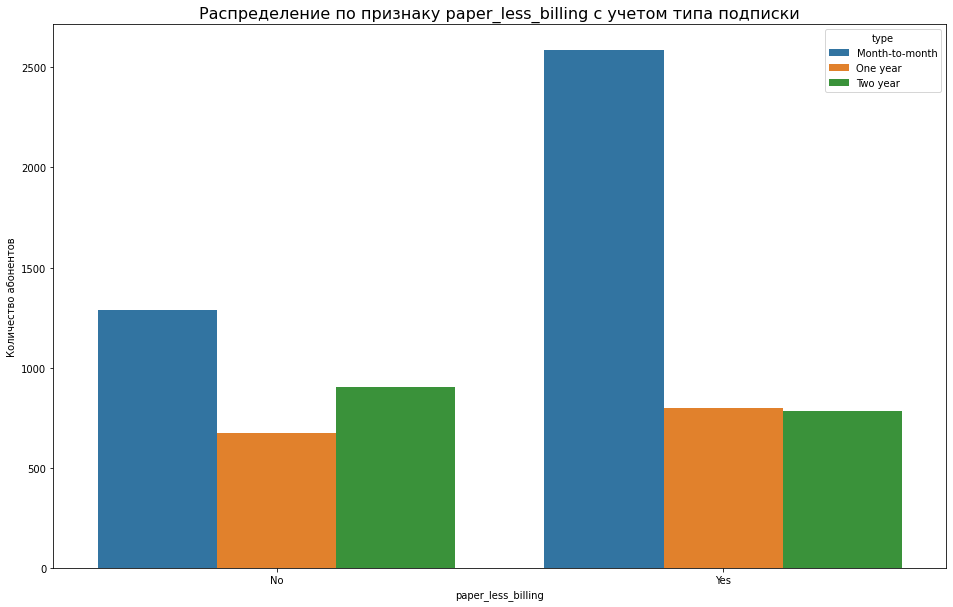

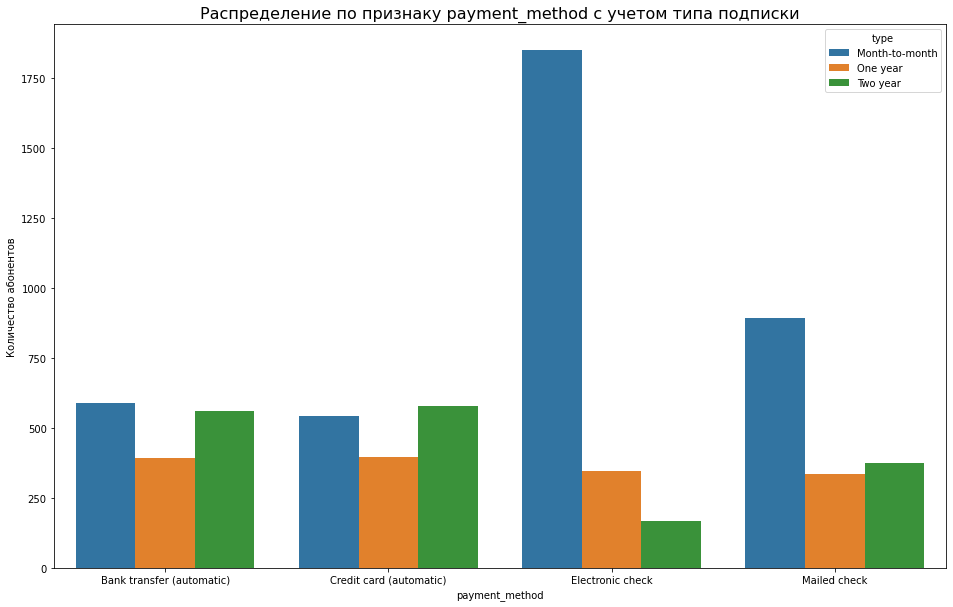

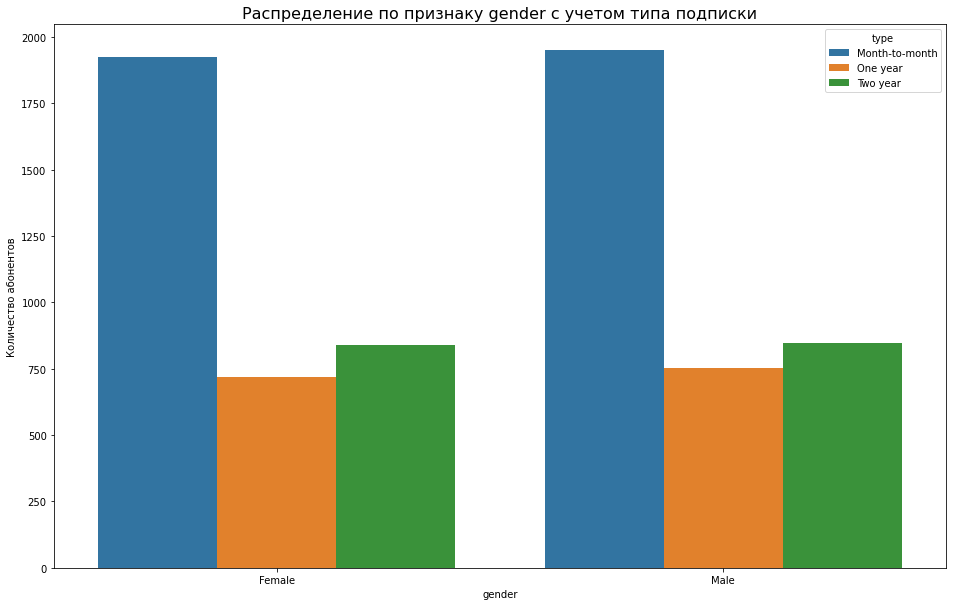

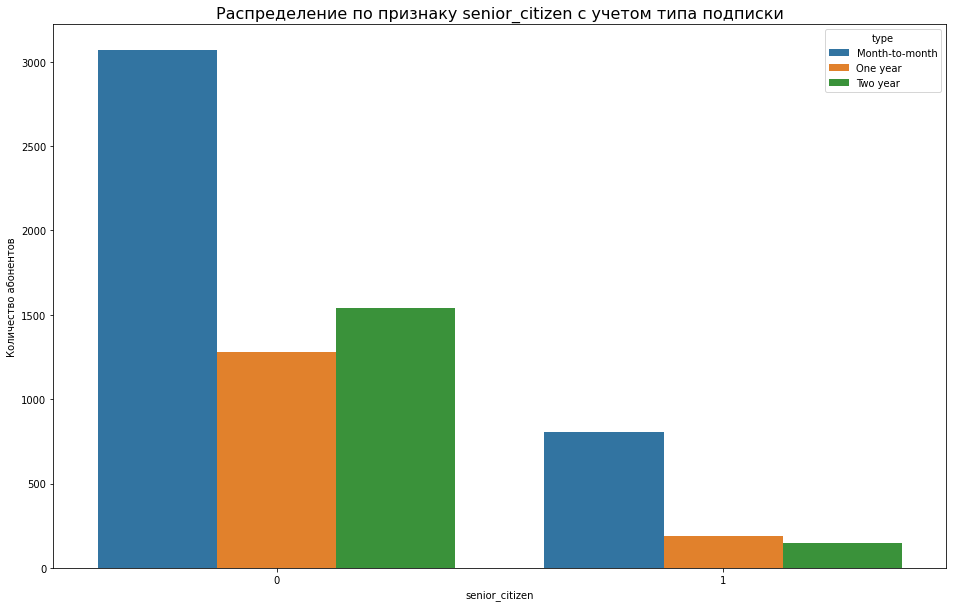

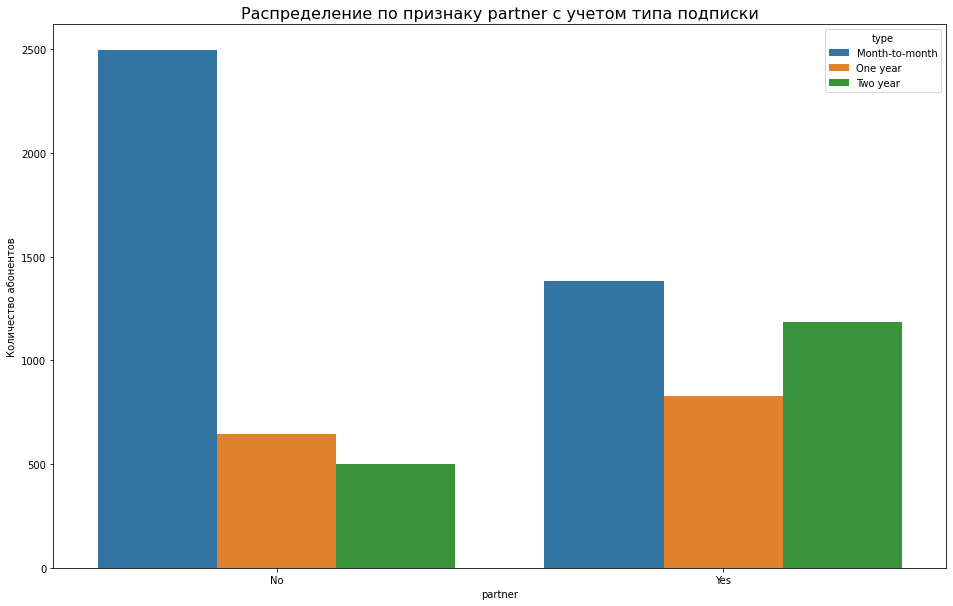

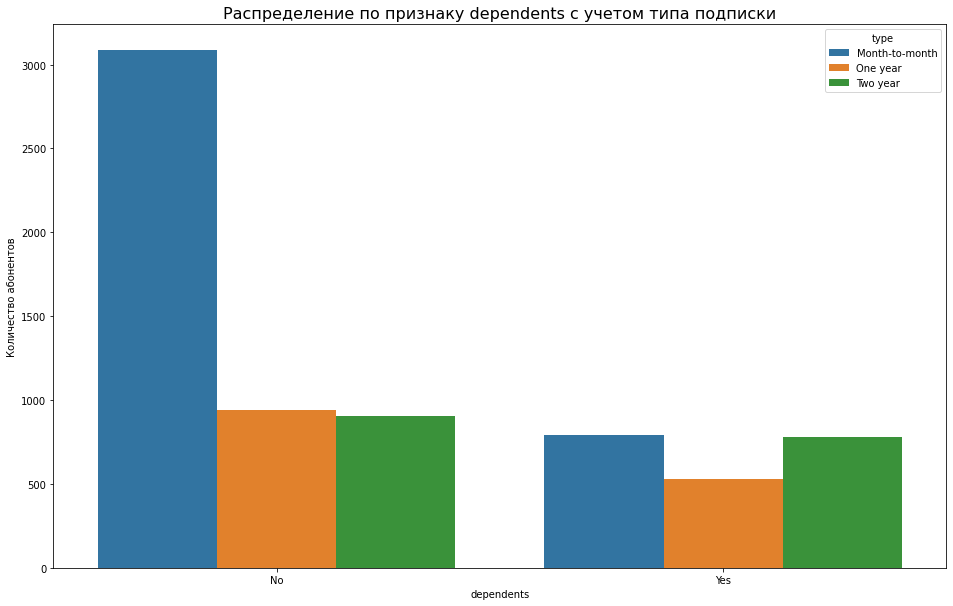

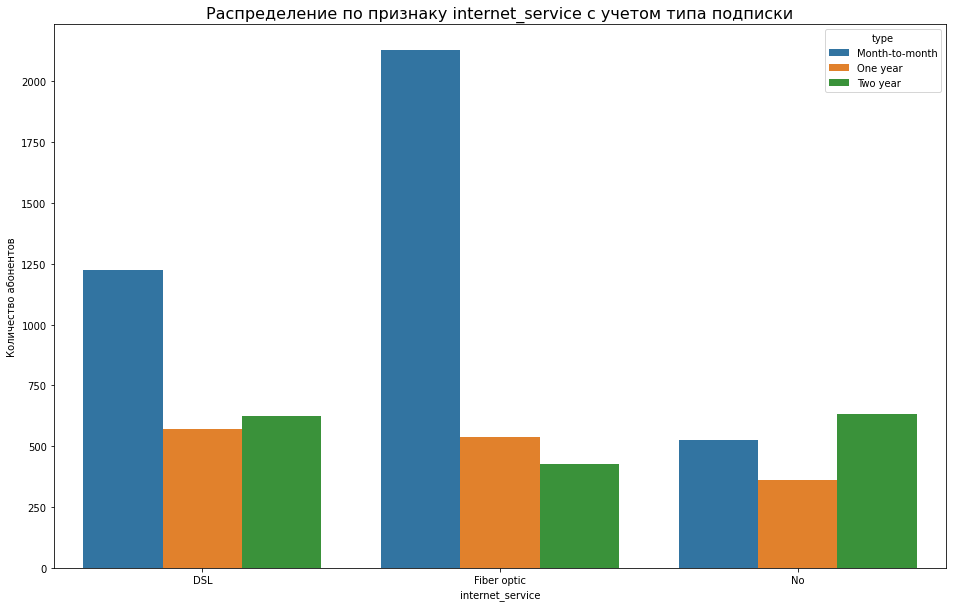

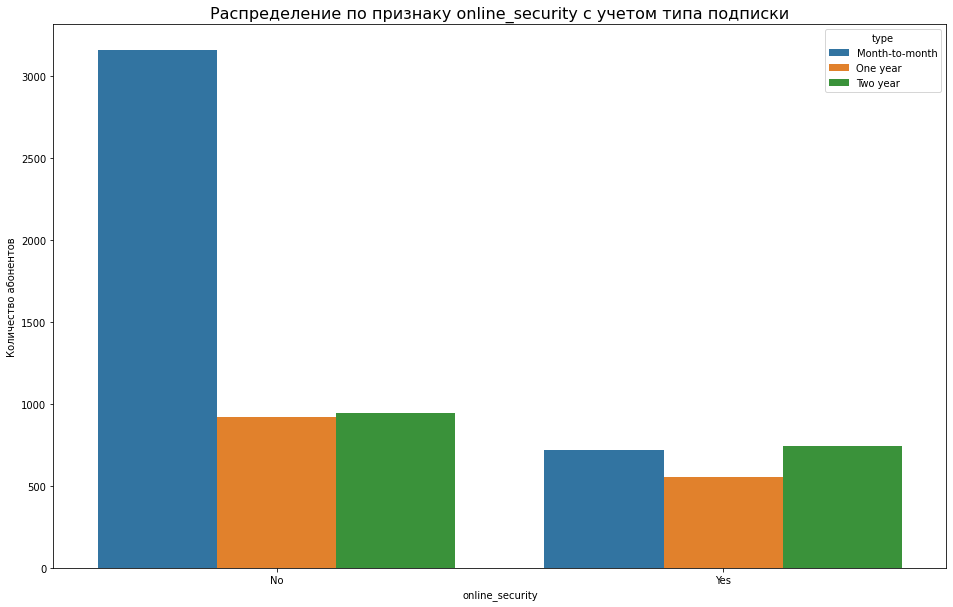

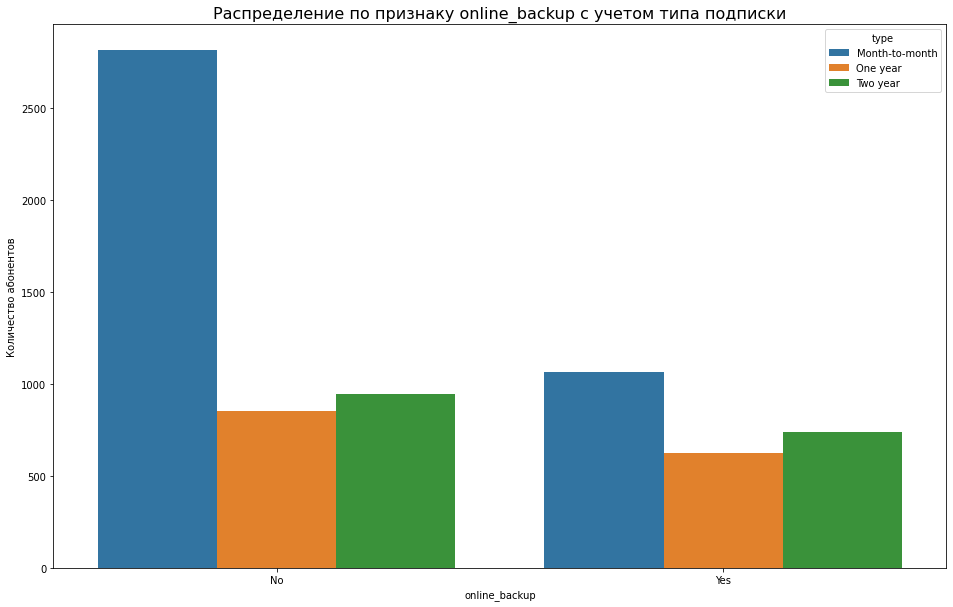

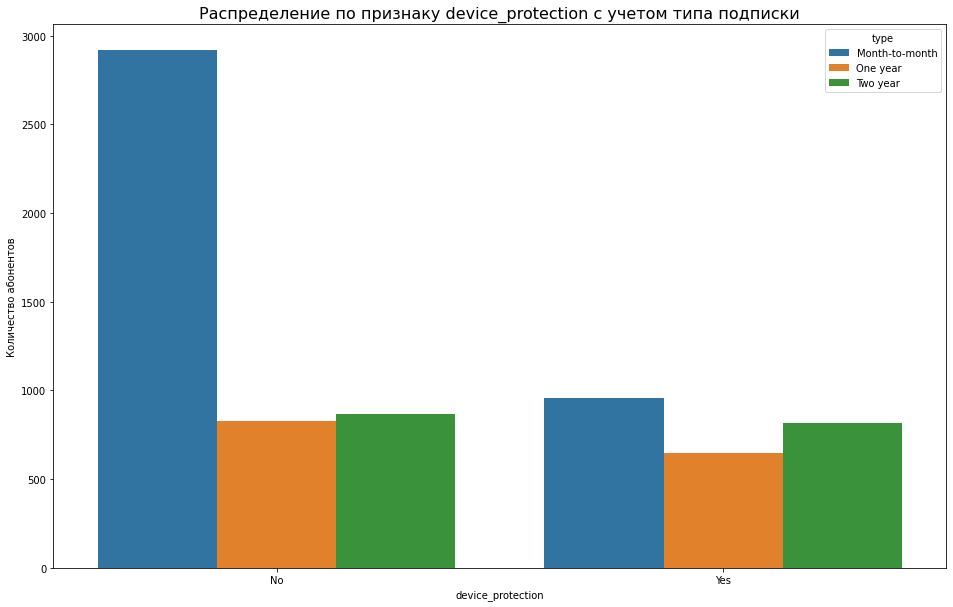

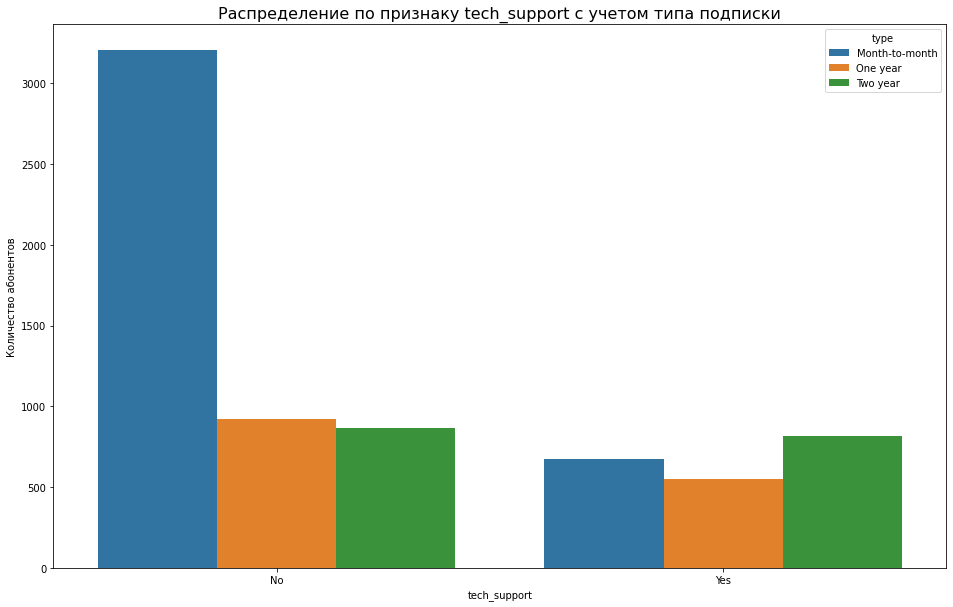

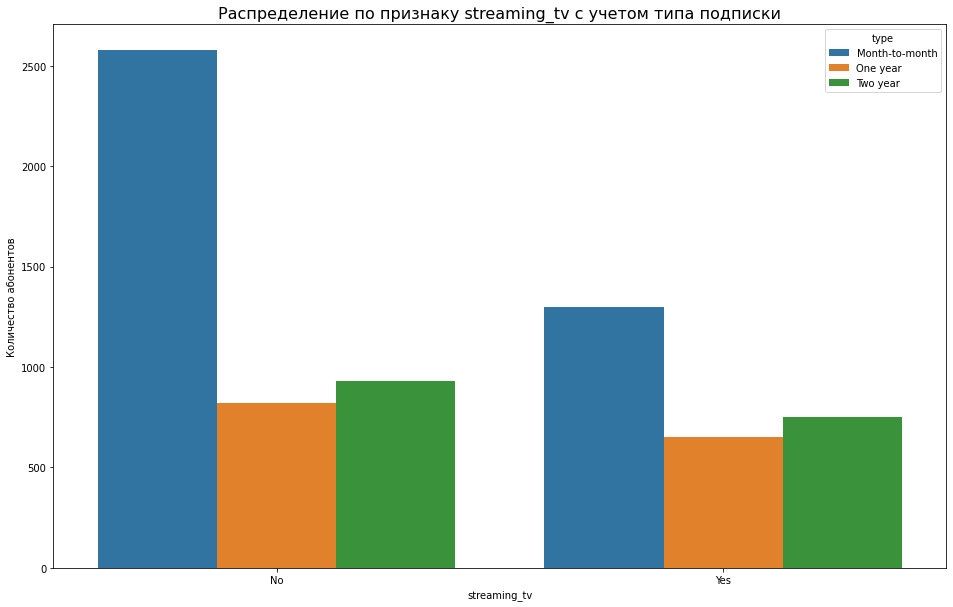

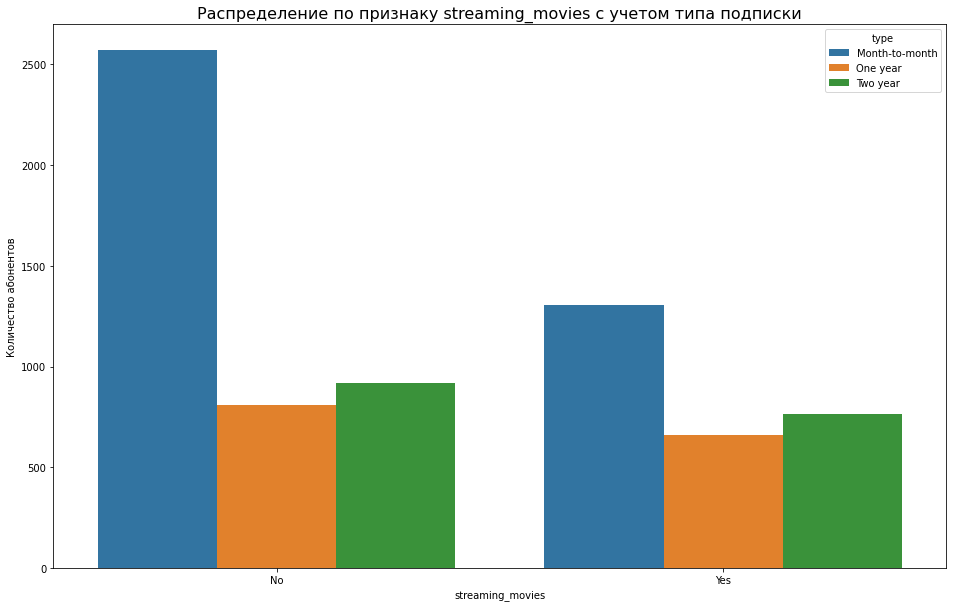

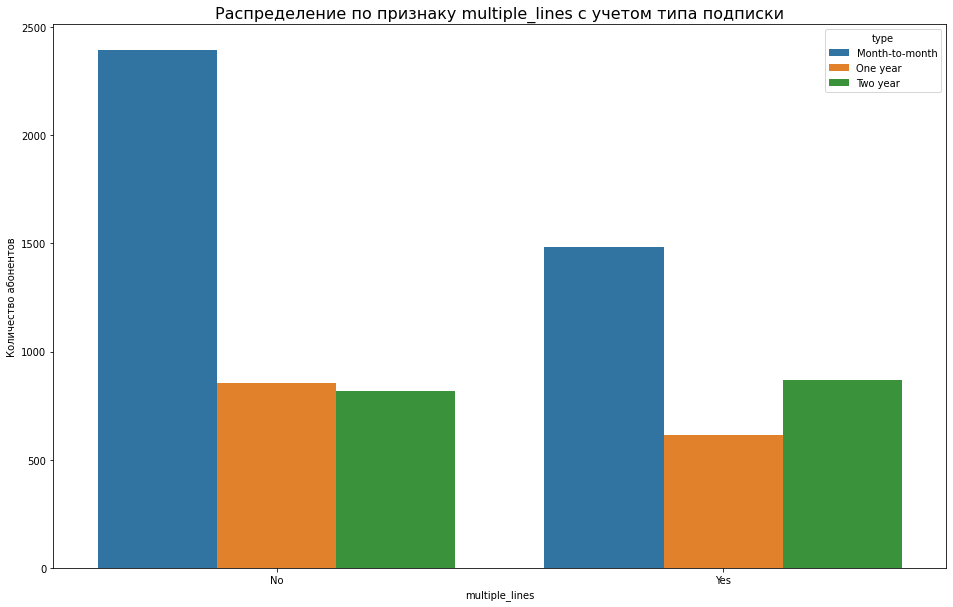

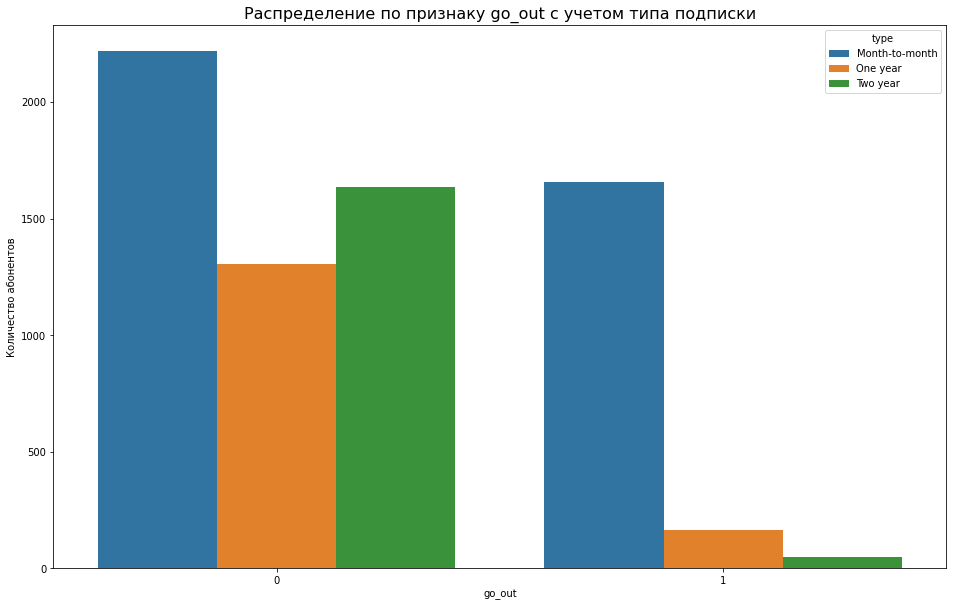

In [41]:
drop_list = ['customer_id', 'begin_date', 'end_date', 'type', 'monthly_charges', 'total_charges',
             'days_passed', 'payments', 'last_pay', 'next_pay', 'days_left', 'days_last_pay']
for i in df.columns.drop(drop_list):
    separation_category_visualization(df, i)

Распределение категориальных признаков для ушедших и оставшихся абонентов:

In [42]:
def type_category_visualization(df, feature):
    fig = plt.figure(figsize=(16,10))
    ax = sns.barplot(x=feature,
                     y='customer_id',
                     hue='go_out',
                     data=(
                         df
                         .groupby([feature, 'go_out'])['customer_id']
                         .count()
                         .reset_index())
                    )
    plt.title('Распределение {} с учетом отписок'.format(feature), fontsize=16)
    plt.ylabel('Количество абонентов')
    plt.xlabel(feature)
    plt.xticks(rotation=0)
    plt.show()

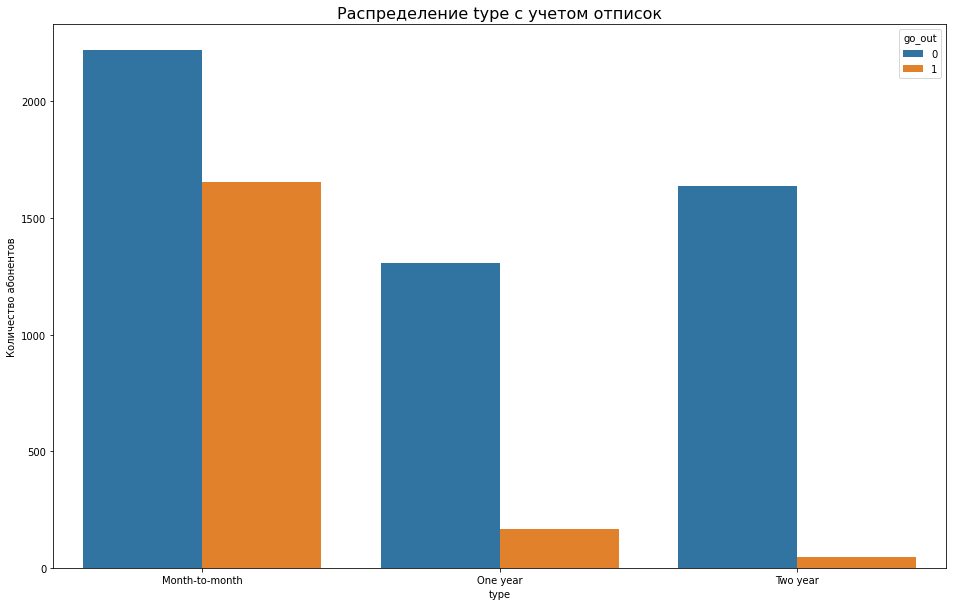

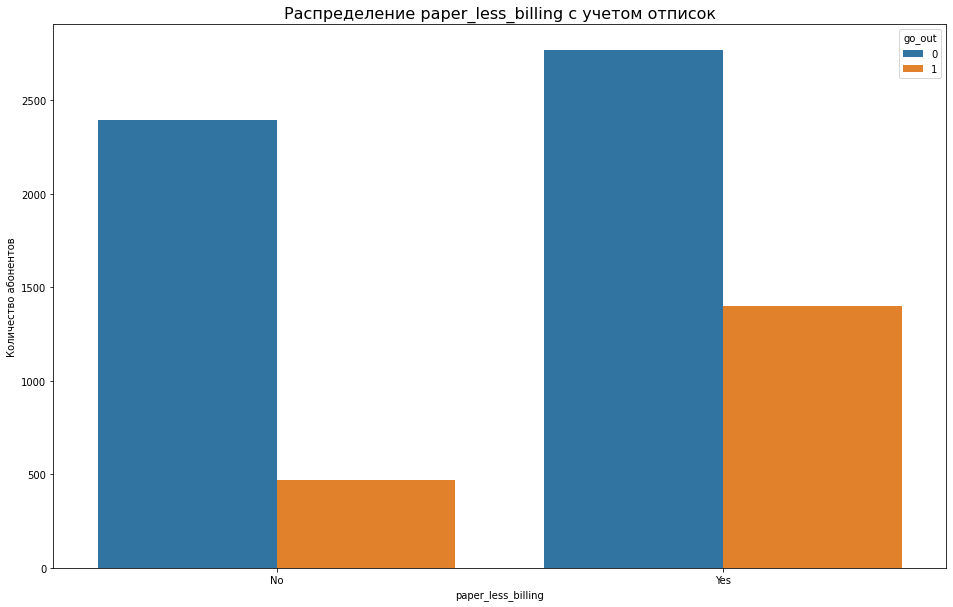

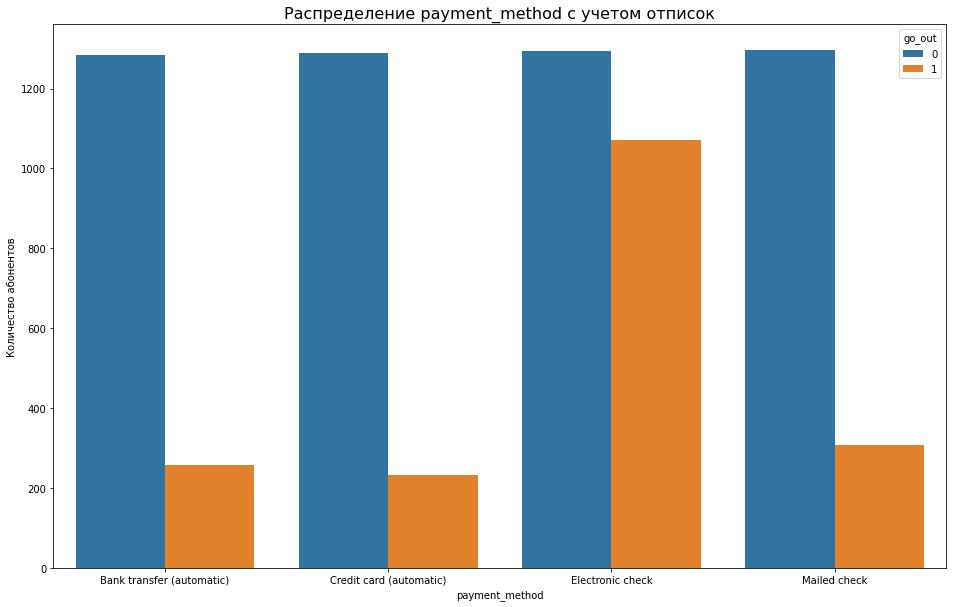

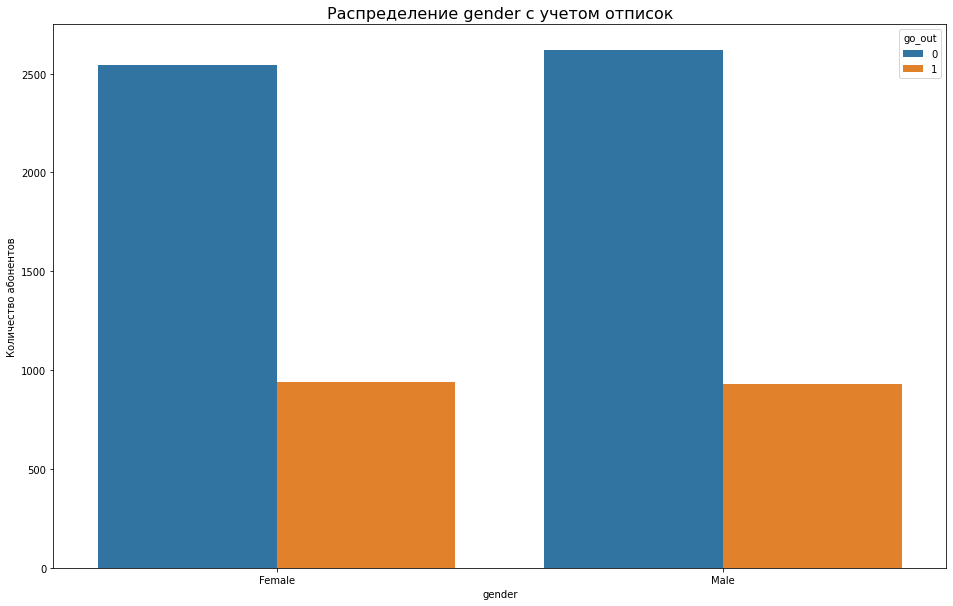

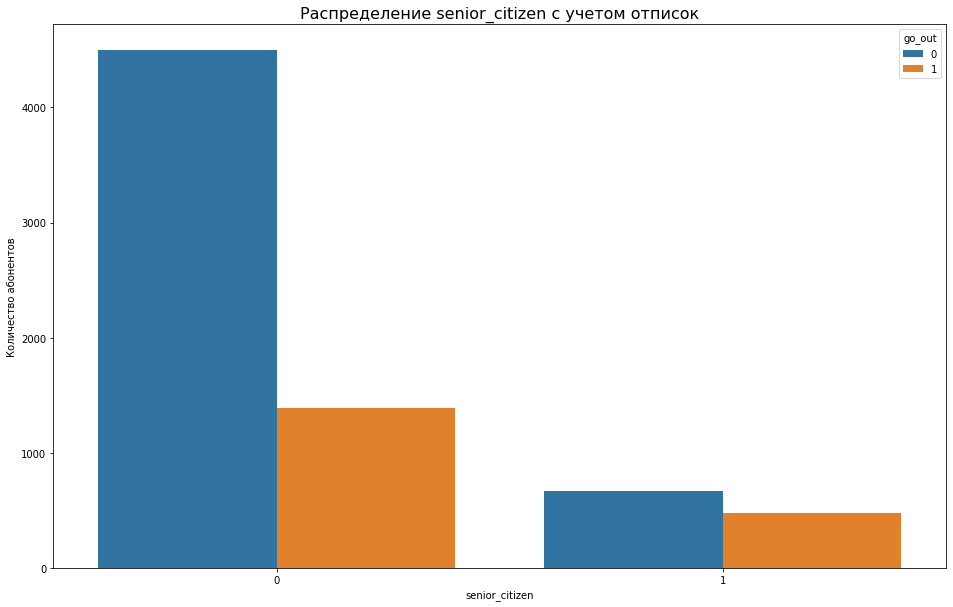

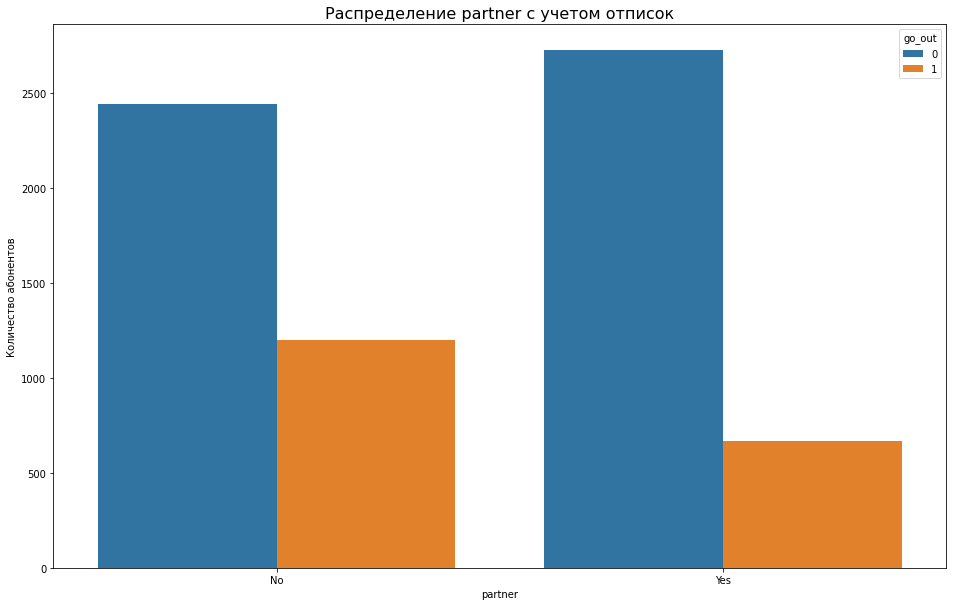

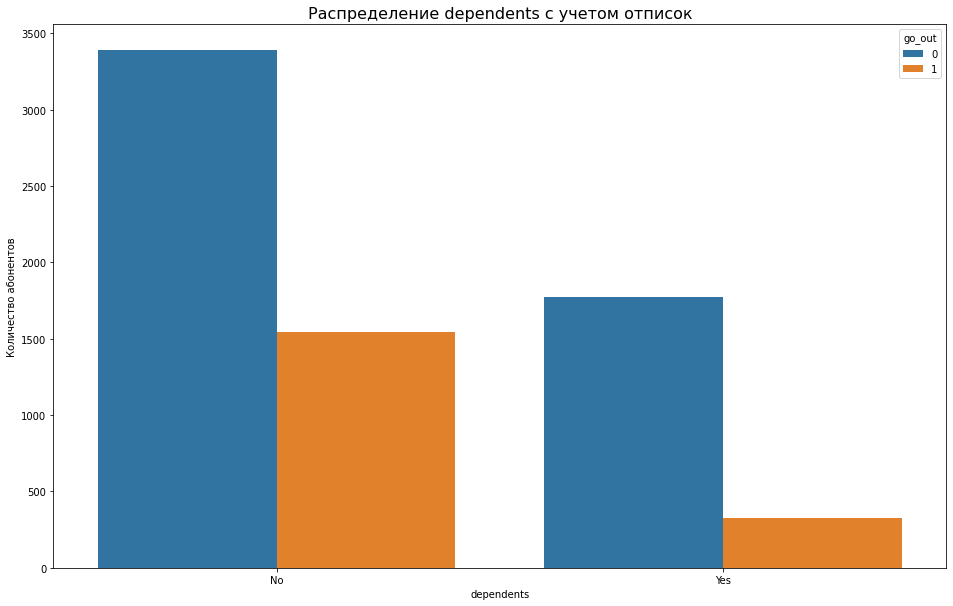

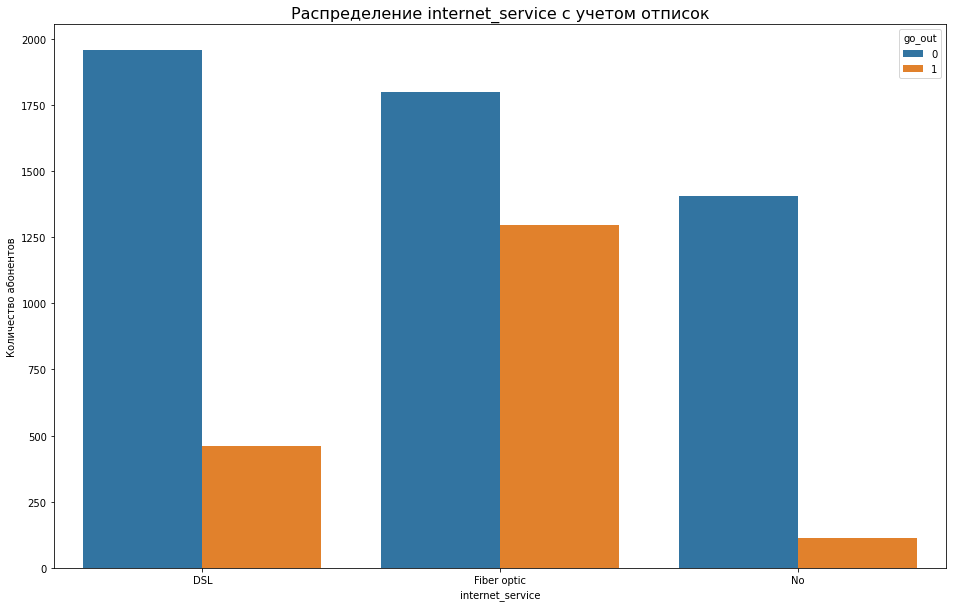

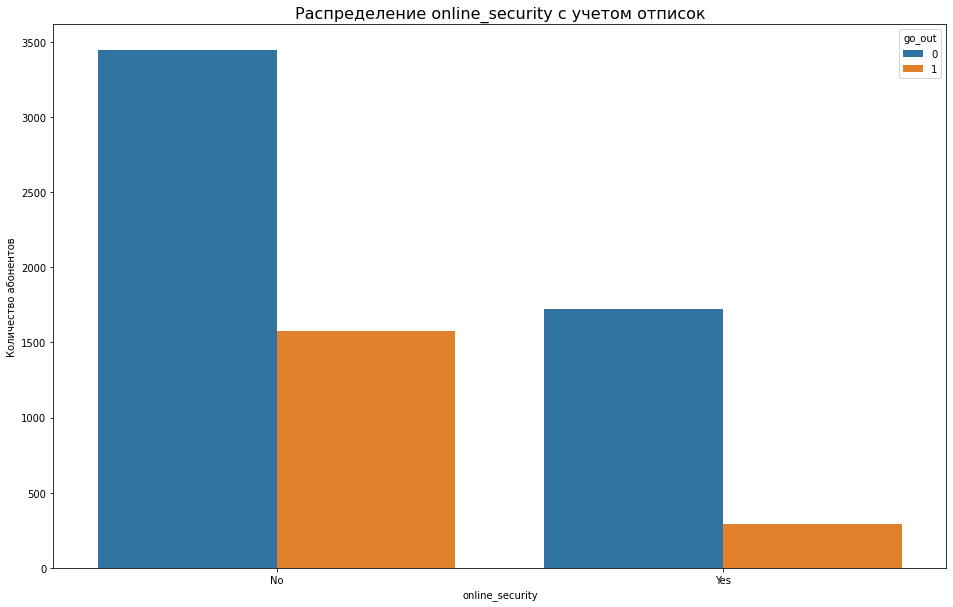

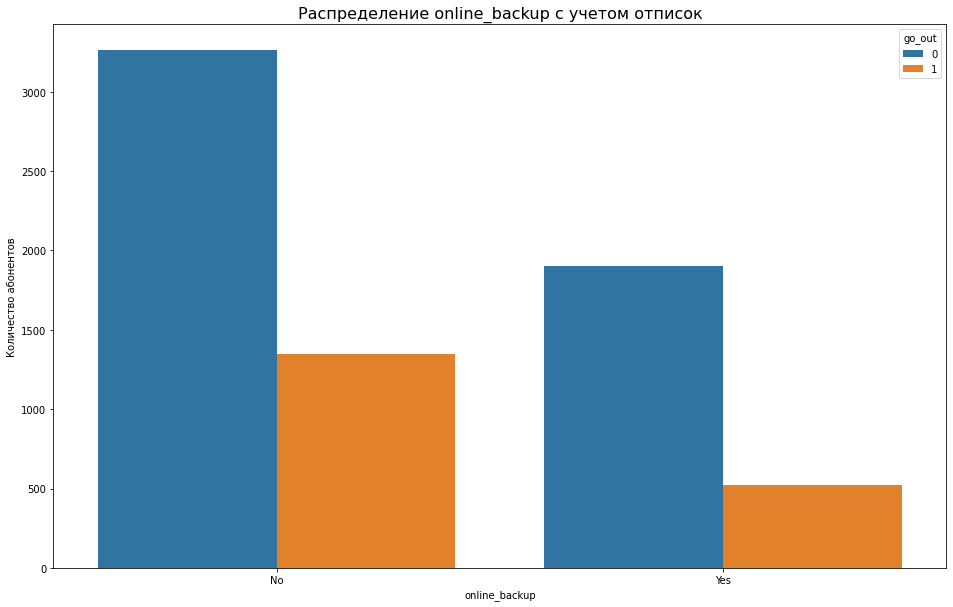

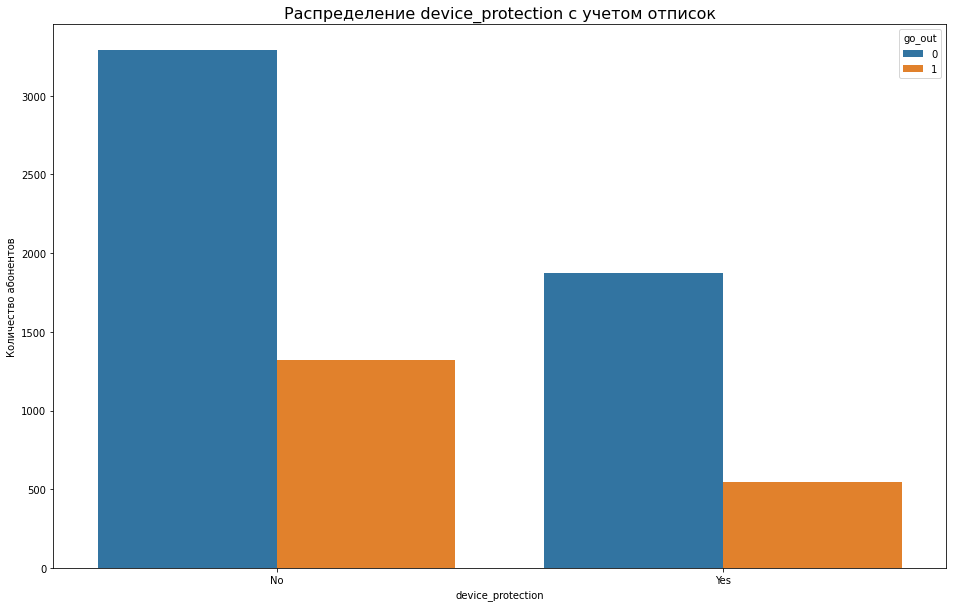

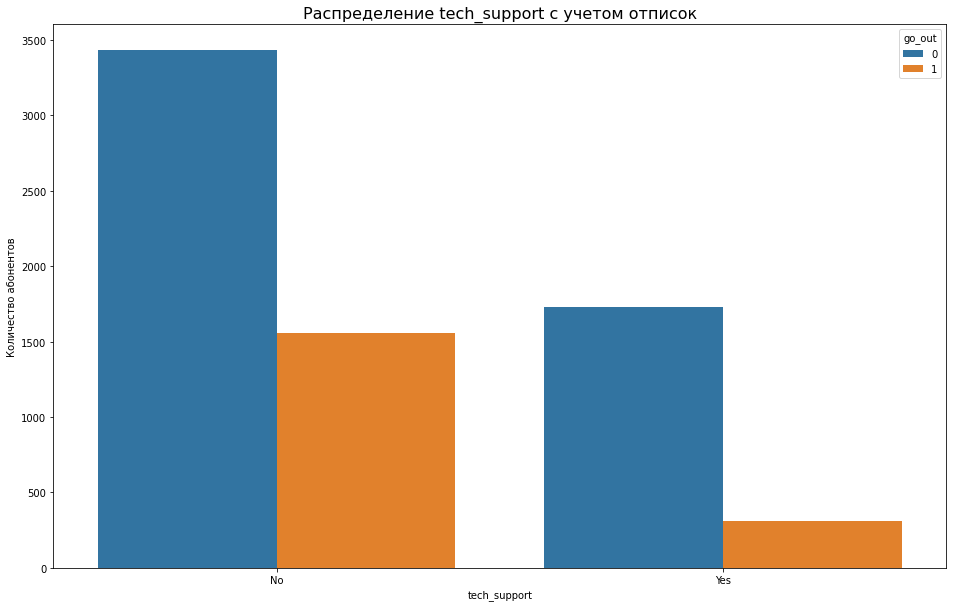

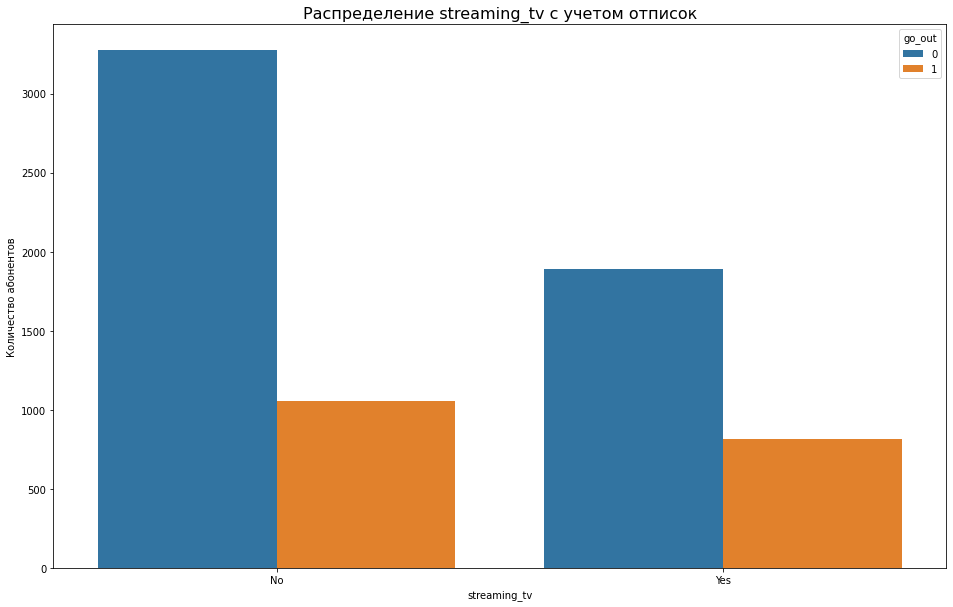

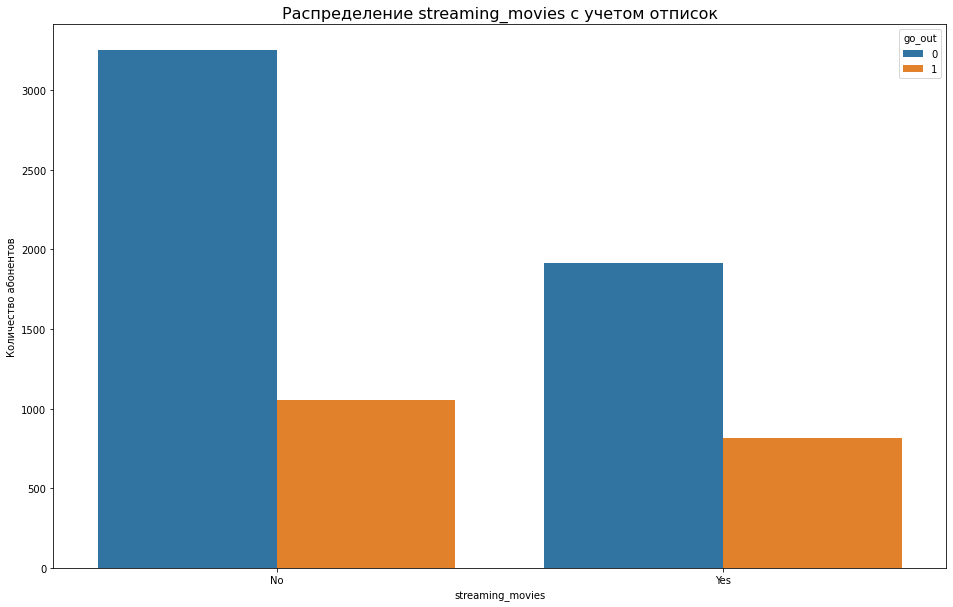

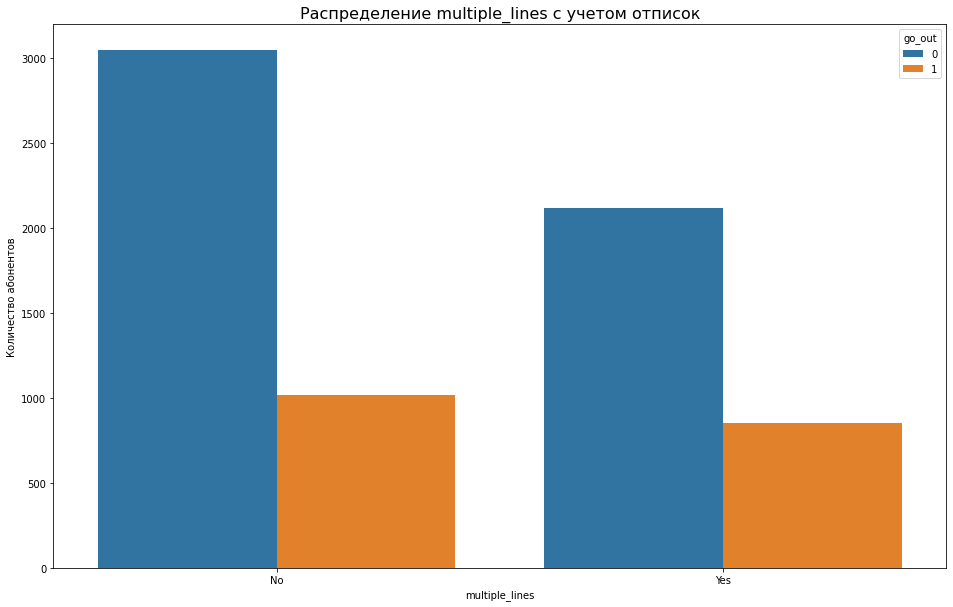

In [43]:
drop_list_catygory = ['customer_id', 'begin_date', 'end_date', 'monthly_charges', 'total_charges', 'go_out', 'end_date',
                      'days_passed', 'payments', 'last_pay', 'next_pay', 'days_left', 'days_last_pay']
for i in df.columns.drop(drop_list_catygory):
    type_category_visualization(df, i)

Распределение по количеству дней использования сервисом:

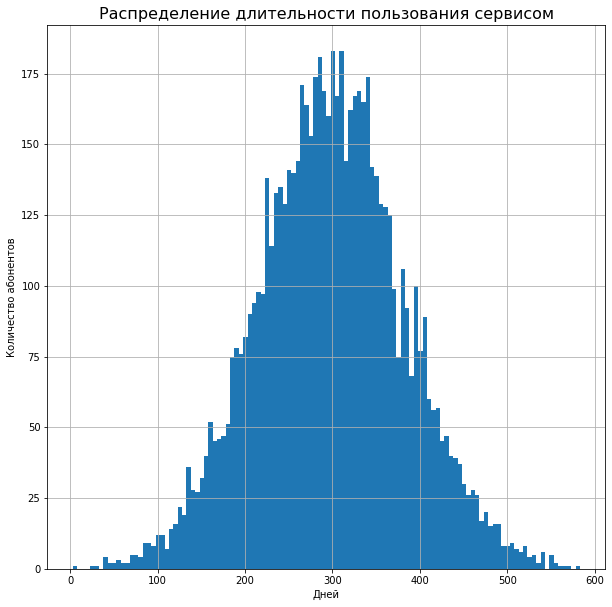

In [44]:
fig = plt.figure(figsize=(10, 10))
df['days_passed'].hist(bins=int((df['days_passed'].max() - df['days_passed'].min()) // 5))
plt.title('Распределение длительности пользования сервисом', fontsize=16)
plt.xlabel('Дней')
plt.ylabel('Количество абонентов')
plt.show()

In [45]:
print('Средняя продолжительность пользования сервисом - {:.1f} дней.'.format(df['days_passed'].mean()))

Средняя продолжительность пользования сервисом - 297.8 дней.


Распределение длительности пользования сервисом имеет вид нормального распределения со средним 297.8 дней.

Диаграммы размаха и распределения абонентов по суммам расходов, в том числе с разделением на ушедших и оставшихся:

In [46]:
def type_charges_visualization(df, abonents):
    fig = plt.figure(figsize=(12, 20))

    ax1 = fig.add_subplot(4, 2, 1)
    ax1 = df['monthly_charges'].hist(bins=int((df['monthly_charges'].max() - df['monthly_charges'].min()) // 5))
    ax1 = plt.title('Распределение расходов за месяц', fontsize=16)
    ax1 = plt.xlabel('Расходы за месяц')
    ax1 = plt.ylabel('Количество абонентов')
    
    ax2 = fig.add_subplot(4, 2, 2)
    ax2 = sns.boxplot(df['monthly_charges'])
    ax2 = plt.title('Диаграмма размаха расходов за месяц', fontsize=16)
    ax2 = plt.xlabel('Расходы за месяц')
    
    ax3 = fig.add_subplot(4, 2, 3)
    ax3 = sns.histplot(data=df, x='monthly_charges', hue='go_out')
    ax3 = plt.title('Распределение расходов за месяц', fontsize=16)
    ax3 = plt.xlabel('Расходы за месяц')
    ax3 = plt.ylabel('Количество абонентов')

    ax4 = fig.add_subplot(4, 2, 5)
    ax4 = df['total_charges'].hist(bins=int((df['total_charges'].max() - df['total_charges'].min()) // 100))
    ax4 = plt.title('Распределение общих расходов', fontsize=16)
    ax4 = plt.xlabel('Общие расходы')
    
    ax5 = fig.add_subplot(4, 2, 6)
    ax5 = sns.boxplot(df['total_charges'])
    ax5 = plt.title('Диаграмма размаха общих расходов', fontsize=16)
    ax5 = plt.xlabel('Общие расходы')
    
    ax6 = fig.add_subplot(4, 2, 7)
    ax6 = sns.histplot(data=df, x='total_charges', hue='go_out')
    ax6 = plt.title('Распределение общих расходов', fontsize=16)
    ax6 = plt.xlabel('Расходы за месяц')
    ax6 = plt.ylabel('Общие расходы')
    
    plt.tight_layout()
    
    fig.suptitle('По данным для {} абонентов'.format(abonents), y=1.03, fontsize=30)

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


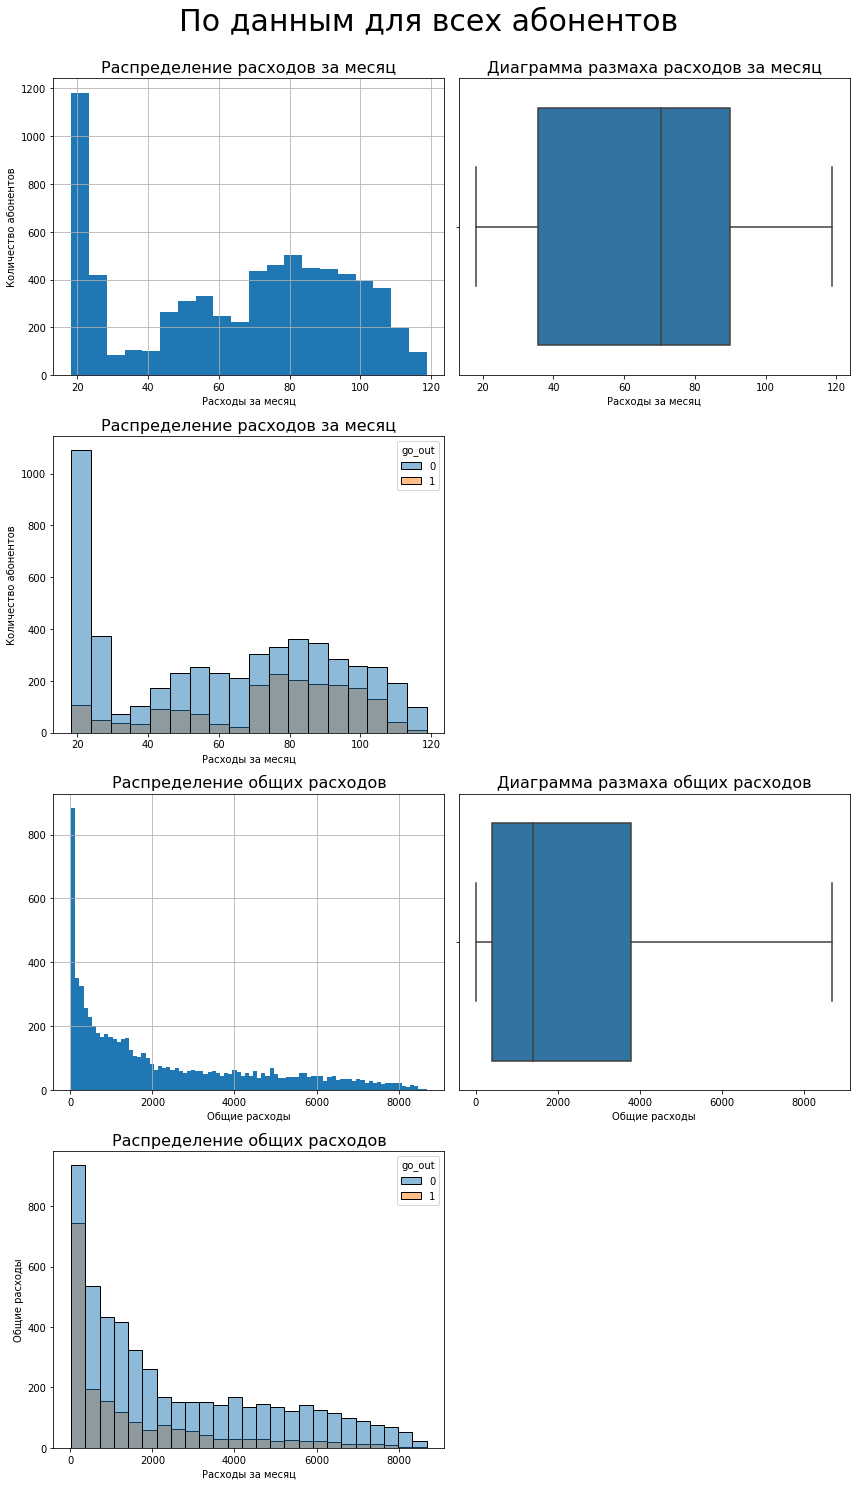

In [47]:
type_charges_visualization(df, 'всех')

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


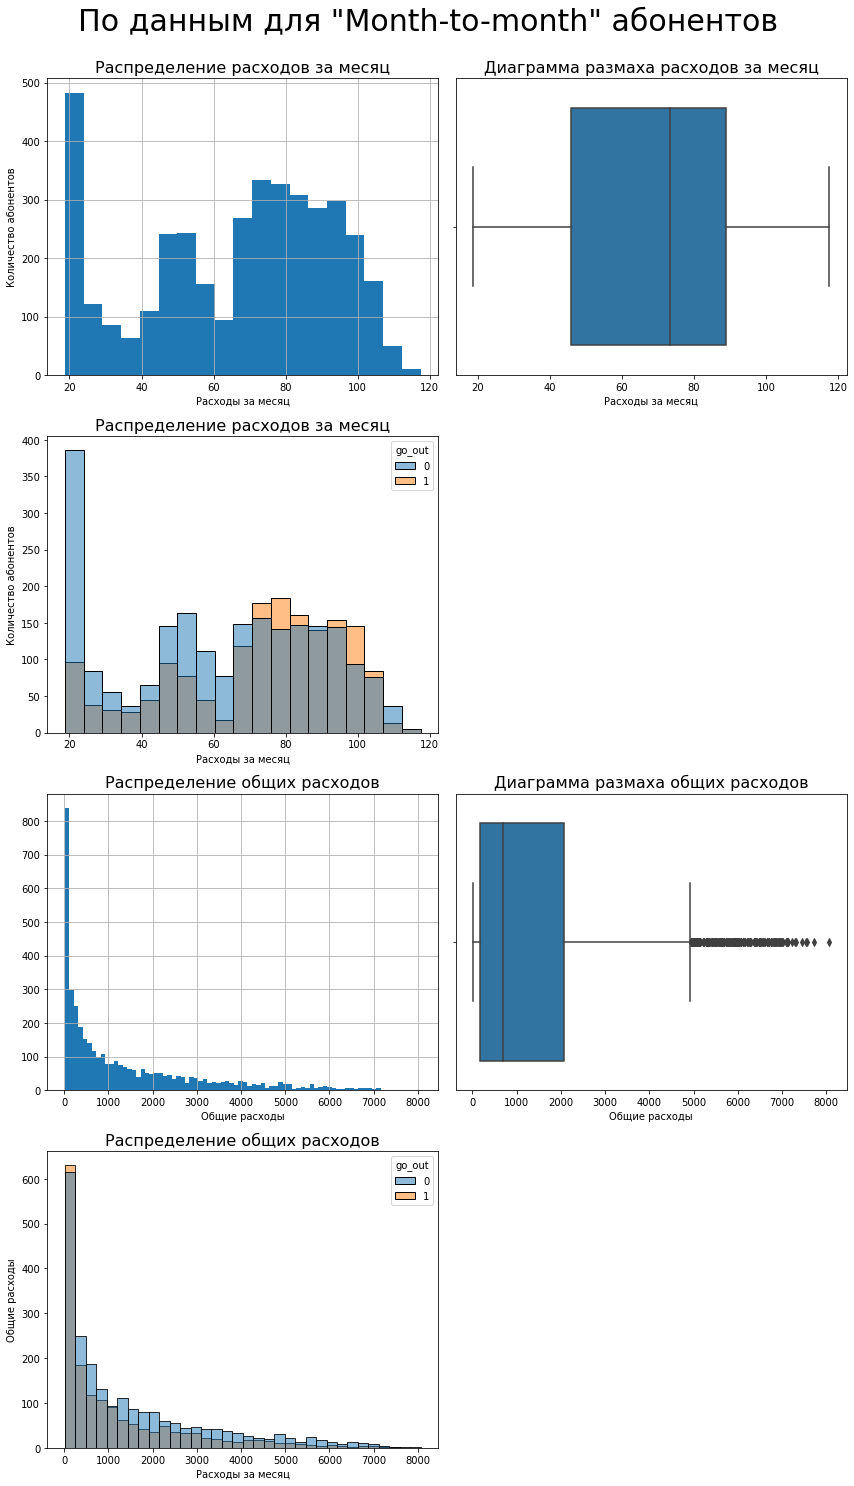

In [48]:
type_charges_visualization(df.loc[df['type'] == 'Month-to-month'].reset_index(drop=True), '"Month-to-month"')

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


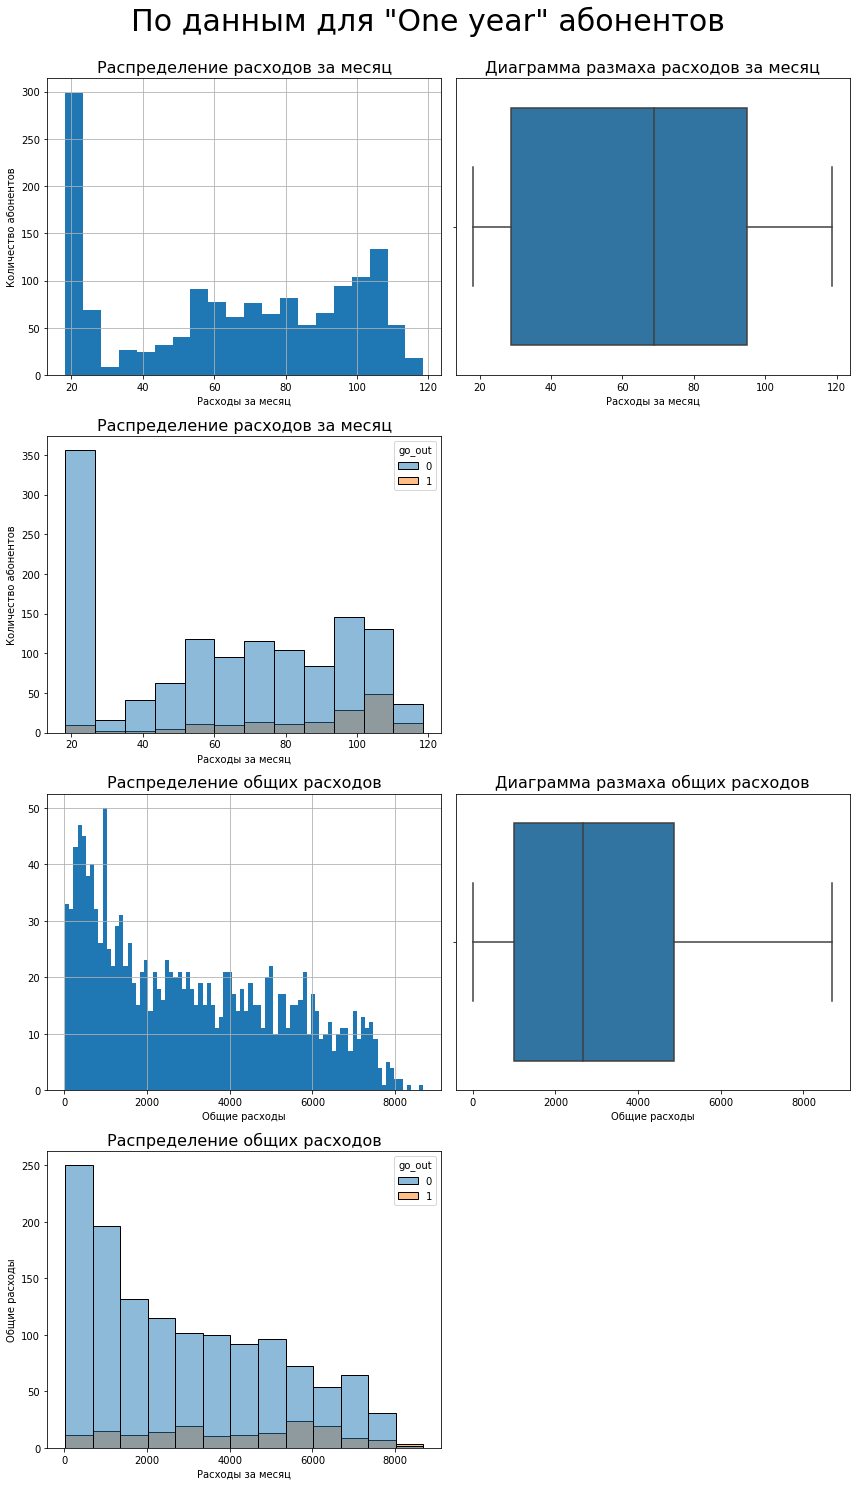

In [49]:
type_charges_visualization(df.loc[df['type'] == 'One year'].reset_index(drop=True), '"One year"')

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


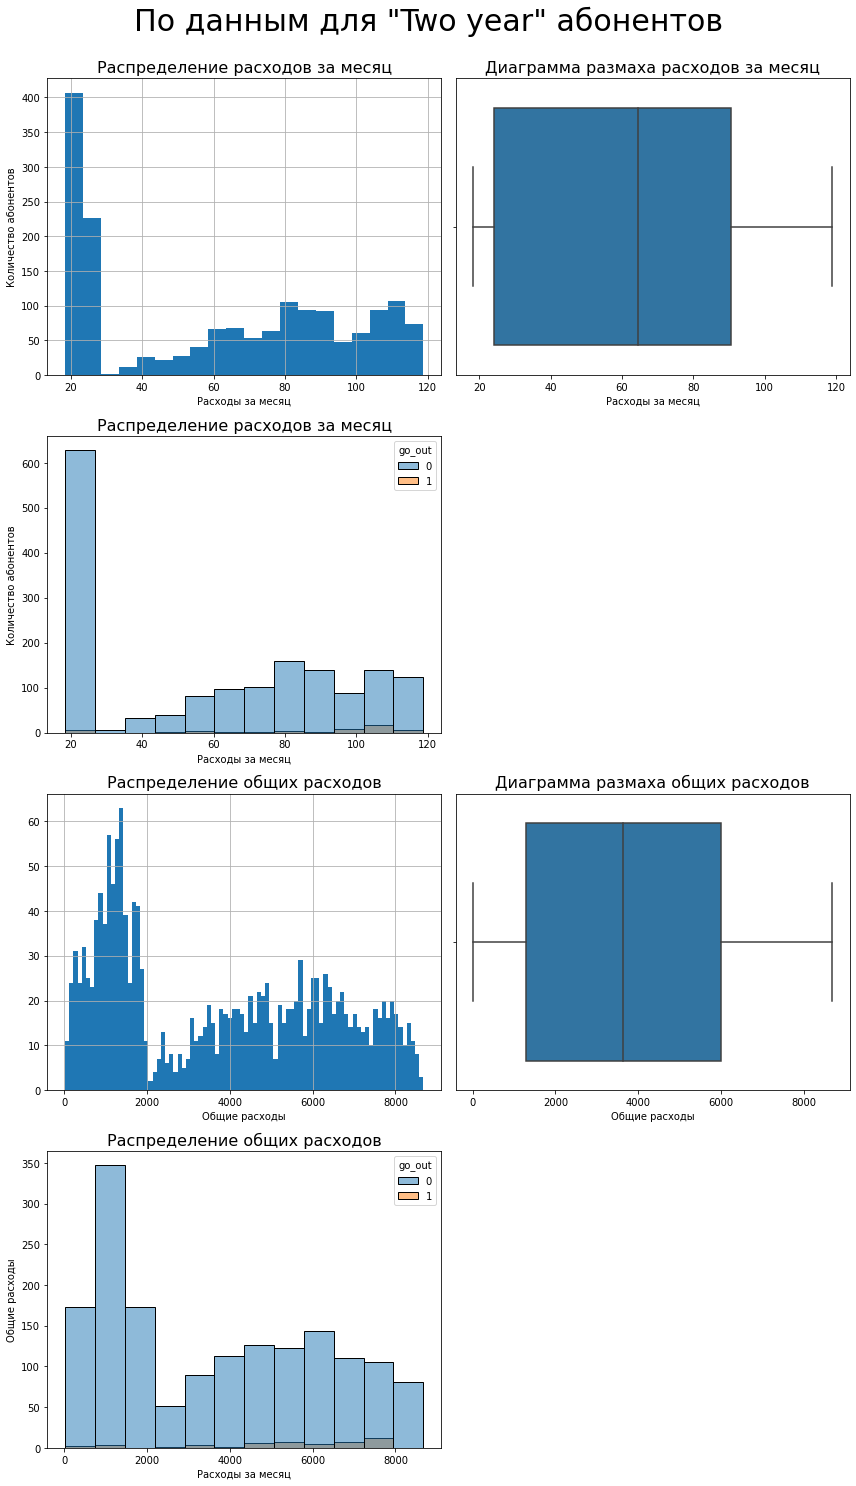

In [50]:
type_charges_visualization(df.loc[df['type'] == 'Two year'].reset_index(drop=True), '"Two year"')

**Анализ корреляции признаков**

Создаем списки категориальных и числовых признаков для расчёта корреляции:

In [51]:
categorical_features_corr = ['type', 'paper_less_billing', 'payment_method', 'gender', 'senior_citizen',
                             'partner', 'dependents','internet_service', 'online_security', 'online_backup',
                             'device_protection', 'tech_support','streaming_tv', 'streaming_movies', 'multiple_lines']
numerical_features_corr = ['monthly_charges', 'total_charges', 'days_passed', 'payments', 'days_left', 'days_last_pay']

Рассчитываем корреляцию категориальных признаков ($\phi_K$):

interval columns not set, guessing: ['senior_citizen']
interval columns not set, guessing: ['senior_citizen']
interval columns not set, guessing: ['senior_citizen']


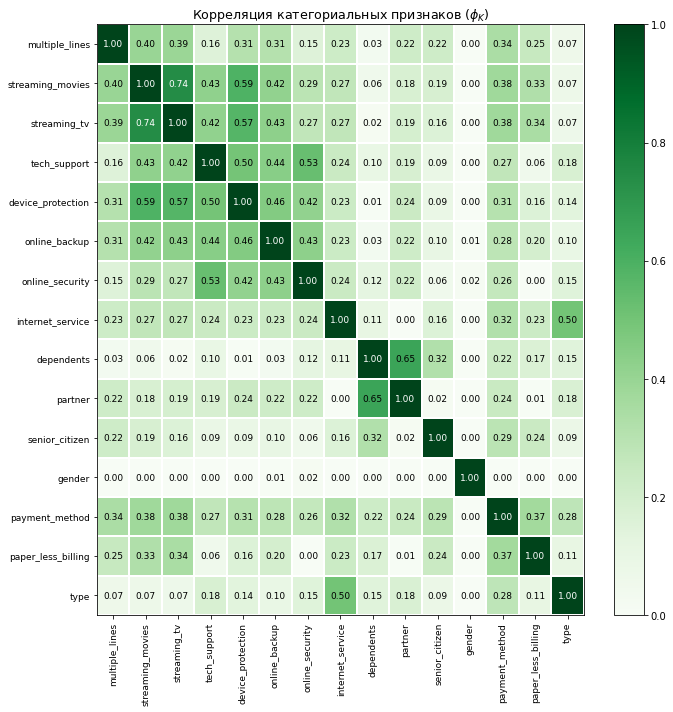

In [52]:
plot_correlation_matrix(df[categorical_features_corr].phik_matrix().values, 
                        x_labels=df[categorical_features_corr].phik_matrix().columns,   # значения x
                        y_labels=df[categorical_features_corr].phik_matrix().index,     # значения y
                        vmin=0, vmax=1,                                                 # минимальное и максимальное значения
                        color_map="Greens",                                             # цветовая палитра
                        title=r"Корреляция категориальных признаков ($\phi_K$)",        # заголовок
                        fontsize_factor=0.9,                                            # коэффициент размера шрифта
                        figsize=(10, 10)                                                # размер окна графика
                       )
plt.show()

Рассчитываем корреляцию числовых признаков. Во избежание негативного влияния нелинейности взаимосвязей признаков применяем коэффициент Спирмена:

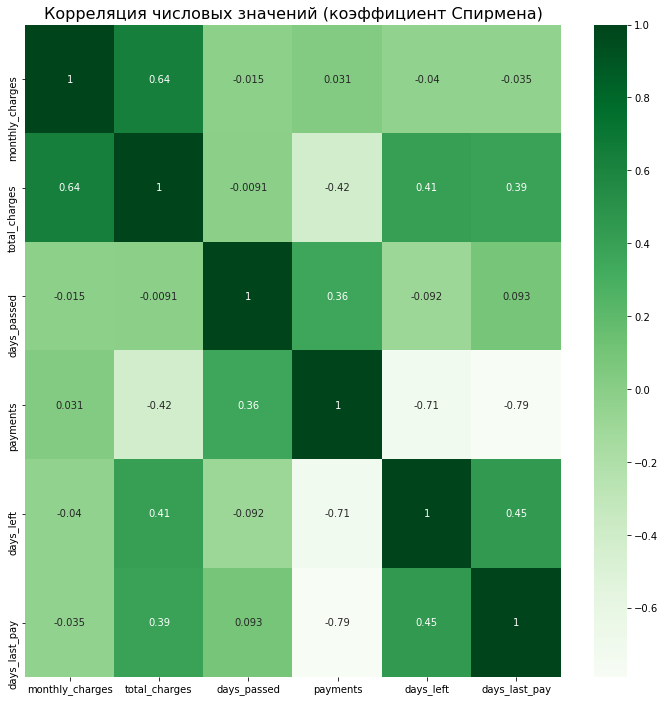

In [53]:
fig = plt.subplots(figsize=(12, 12))
sns.heatmap(df[numerical_features_corr].corr(method = 'spearman'), annot = True, cmap = 'Greens')
plt.title('Корреляция числовых значений (коэффициент Спирмена)', fontsize=16)
plt.show()

Высокая степень корреляции наблюдается у признаков streaming_tv и streaming_movies - 0,74. Один из них необходимо исключить из исследования. Поскольку у streaming_movies степень корреляции с остальными категориальными признаками выше, нежели у streaming_tv, исключаем его.

### Подготовка данных
<a id="section_2_3"></a>

Создаем списки категориальных и числовых признаков для обучения моделей:

In [54]:
categorical_features = ['type', 'paper_less_billing', 'payment_method', 'gender', 'senior_citizen', 'partner', 'dependents',
                        'internet_service', 'online_security', 'online_backup', 'device_protection', 'tech_support',
                        'streaming_tv', 'multiple_lines']
numerical_features = ['total_charges', 'monthly_charges', 'days_passed', 'payments', 'days_left', 'days_last_pay']

Собираем необходимые для обучения признаки в датафрейм и выделяем целевой признак:

In [55]:
X = df[categorical_features + numerical_features]
y = df['go_out']

Разделяем выборку на обучающую и тестовую. Поскольку при обучении моделей будет использоваться кросс-валидация, нет необходимости выделять валиданионную выборку.

In [56]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y, shuffle=True, random_state=RS)
X_train = X_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

Производим масштабирование значений числовых признаков и кодировку посредством OneHotEncoder категориальных значений:

In [57]:
class ScalerTransformation(BaseEstimator, TransformerMixin):
    '''класс обучения и трансформации для масштабирования числовых признаков'''
    scaler = StandardScaler()
    
    def fit(self, X, y=None):
        X = X.copy()                                                     # делаем копию матрицы признаков
        self.scaler.fit(X[numerical_features])                           # обучаем scaler на числовых данных обучающей выборки
        return self
    
    def transform(self, X, y=None):
        X = X.copy()                                                           # делаем копию матрицы признаков
        X[numerical_features] = self.scaler.transform(X[numerical_features])   # масштабируем числовые значения
        return X

In [58]:
class OheEncoder(BaseEstimator, TransformerMixin): 
    '''класс обучения и трансформации для кодирования категориальных признаков'''
    
    encoder = OneHotEncoder(handle_unknown='ignore', drop='first')
    
    def fit(self, X, y=None):
        X = X.copy()                                      # делаем копию матрицы признаков
        self.encoder.fit(X[categorical_features])         # обучаем encoder на категориальных данных обучающей выборки
        return self
    
    def transform(self, X):
        X = X.copy()                                                                 # делаем копию матрицы признаков
        feature_arr = self.encoder.transform(X[categorical_features]).toarray()      # кодируем категориальные значения
        ohe_labels = self.encoder.get_feature_names_out(categorical_features)        # создаем список названий новых признаков
        features = pd.DataFrame(                                                     # собираем результаты в датафрейм
               feature_arr,
               columns=ohe_labels)
        X = X.join(features)                                         # добавляем результаты кодирования в исходную таблицу
        X = X.drop(categorical_features, axis=1)                     # удаляем исходные категориальные столбцы
        X.columns = map(str.lower, X.columns)                        # переводим названия столбцов в нижний регистр
        
        return X

In [59]:
pipe = make_pipeline(ScalerTransformation(), OheEncoder())
pipe.fit(X_train)

Pipeline(steps=[('scalertransformation', ScalerTransformation()),
                ('oheencoder', OheEncoder())])

Данные для модели RandomForestClassifier (категориальные значения закодированы, числовые - отмасштабированы):

In [60]:
X_train_rfc = pipe.transform(X_train)
X_test_rfc = pipe.transform(X_test)

Данные для модели NeuralNetClassifier (закодированные, отмасштабированые данные переведены и целевой признак в тензоры):

In [61]:
X_train_nn = torch.FloatTensor(np.array(X_train_rfc))
y_train_nn = torch.FloatTensor(np.array(y_train))
X_test_nn = torch.FloatTensor(np.array(X_test_rfc))
y_test_nn = torch.FloatTensor(np.array(y_test))

Поскольку для модели CatBoostClassifier не требуется масштабирование и кодирование, для нее будут использоваться исходные обучающая и тестовая выборки:  
- X_train;
- y_train;
- X_test;
- y_test.

Проверяем обучающую выборку на дисбаланс классов:

In [62]:
print('Доля положительных значений целевого признака: {:.2f}.'.format(y_train.mean()))

Доля положительных значений целевого признака: 0.27.


**Вывод:**  
1. Анализ исходных данных.  
- df_contract:  
В датафрейме 7043 строк. Присутствуют пропуски в данных по дате окончания договора (73%) и в данных по общим расходам (0,15%).  
В датафрейме 4 уникальных даты окончания договора.  
Дубликаты по идентификационному номеру абонента отсутствуют.  
Наибольшим спросом пользуется подписка на месяц.    
Чаще электронный расчётный лист используется абонентами, имеющими подписку на месяц.  
Самый популярный метод расчёта - Electronic check, в основном, за счет абонентов, имеющих подписку на месяц.  
Аномальные значения по ежемесячным и общим расходам отсутствуют.  

- df_personal:  
В датафрейме 7043 строк.  
Пропущенных значений нет.  
Все признаки, кроме идентификатора абонента - бинарные.  
В выборке не дисбаланса по признаку пола (gender) и наличия супруга или супруги (partner).  
Количество пенсионеров в 6 раз меньше, чем не пенсионеров.  
Количество абонентов с детьми в 2,5 меньше, чем бездетных.  

- df_internet:  
В датафрейме 5517 строк.  
Пропущенных значений нет.  
Все признаки, кроме идентификатора абонента - бинарные.  

- df_phone:  
В датафрейме 6361 строк.  
Пропущенных значений нет.  
Признак multiple_lines - бинарный.  


2. Анализ объединенной таблицы.   
В датафрейме 7032 строк. Пропущенные значения отсутствуют.  
В датафрейм добавлены следующие признаки:
- payments - количество платежей;
- days_passed - количество дней, которое действует или действовал договор;
- days_left - количество дней до следующего платежа;
- days_last_pay - количество дней, прошедших с даты последнего платежа.

Анализ признаков:
- type:  
Чем длительней срок подписки, тем меньше отписок.

- paper_less_billing:  
Чаще электронный расчётный лист используется абонентами, имеющими подписку на месяц.  
От подписки чаще отказываются те, кто пользуются электронным расчётным листом.

- payment_method:  
Самый популярный метод расчёта - Electronic check, в основном, за счет абонентов, имеющих подписку на месяц. Семейные абоненты предпочитают годовую или двухлетнюю подписку.    
От подписки чаще отказываются те, кто пользуются методом оплаты Electronic check.

- gender:  
Как мужчины, так и женщины наиболее часто пользуются подпиской на месяц.  
Так же они в равной степени отказываются от подписки.

- senior_citizen:  
Среди пользователей всех типов подписок большинство - не пенсионеры.  
Пенсионеры реже отказываются от подписки.

- partner:  
Среди пользователей, имеющий месячную подписку, - холостые. Большинство абонентов, имеющий годовую или двухгодичную подписку, - семейные.  
Находящиеся в браке абоненты реже отказываются от подписки.

- dependents:  
Наибольшая группа абонентов - бездетные абоненты с подпиской на месяц.  
Доля отказывающихся от подписки выше у бездетных абонентов.

- internet_service:  
Количество абонентов с годовой и двухлетней подпиской равномерно распределены по типу подключения - около 500 на каждый тип. Абоненты с месячной подпиской предпочитают тип подключения Fiber optic. - около 2000.  
Большинство отказов от подписки - у абонентов с подключением Fiber optic.

- online_security:  
Абоненты всех трех типов подписки чаще не пользуются блокировкой опасных сайтов. Особенно этим злоупотребляют абоненты с месячной подпиской - свыше 3000 абонентов.  
Доля отказов от подписки выше у пользователей, которые не пользуются блокировкой опасных сайтов.

- online_backup:  
Количество абонентов с годовой и двухлетней подпиской в равной степени как пользуются, так и не пользуются резервным копированием. Абоненты с месячной подпиской предпочитают не использовать резервное копирование.  
Доли отказов от подписки у абонентов, использующих резервное копирование и не использующих, сопоставимы.

- device_protection:  
Количество абонентов с годовой и двухлетней подпиской в равной степени как пользуются, так и не пользуются антивирусом. Абоненты с месячной подпиской предпочитают не использовать антивирус.  
Доли отказов от подписки у абонентов, использующих антивирус и не использующих, сопоставимы.

- tech_support:  
Количество абонентов с годовой и двухлетней подпиской в равной степени как пользуются, так и не пользуются выделенной линией техподдержки. Абоненты с месячной подпиской предпочитают не использовать выделенную линиею техподдержки.  
Доля отказов от подписки выше у пользователей, которые пользуются выделенной линией техподдержки.

- streaming_tv:  
Количество абонентов с годовой и двухлетней подпиской в равной степени как пользуются, так и не пользуются стриминговым телевидением. Абоненты с месячной подпиской предпочитают не пользоваться стриминговым телевидением.  
Доля отказов от подписки выше у пользователей, которые пользуются стриминговым телевидением.

- streaming_movies:  
Количество абонентов с годовой и двухлетней подпиской в равной степени как пользуются, так и не пользуются каталогом фильмов. Абоненты с месячной подпиской предпочитают не пользоваться каталогом фильмов.  
Доля отказов от подписки выше у пользователей, которые пользуются каталогом фильмов.

- multiple_lines:  
Количество абонентов с годовой и двухлетней подпиской в равной степени как пользуются, так и не пользуются подключением телефона к нескольким линиям. Абоненты с месячной подпиской предпочитают не пользоваться подключеним телефона к нескольким линиям.  
Доля отказов от подписки выше у пользователей, которые пользуются подключеним телефона к нескольким линиям.

- days_passed (пользования сервисом):  
Распределение длительности пользования сервисом имеет вид нормального распределения со средним 297.8 дней.  

Для абонентов с месячной подпиской есть выбросы в большую сторону значений общих расходов. При этом для месячных расходов выбросов нет. Из этого можно сделать вывод, что выбросы по общим расходом относятся к абонентам, пользующимися сервисом длительное время. Эти значения не являются аномальными.  

Высокая степень корреляции наблюдается у признаков streaming_tv и streaming_movies - 0,74. Один из них необходимо исключить из исследования. Поскольку у streaming_movies степень корреляции с остальными категориальными признаками выше, нежели у streaming_tv, исключаем его.  


3. Подготовка данных.  

Выборка разделена на обучающую и тестовую.  
Для модели RandomForestClassifier категориальные значения закодированы, числовые - отмасштабированы (OHE). Выборки имеют следующие наименования:  
 - X_train_rfc;
 - y_train;
 - X_test_rfc;
 - y_test.  
 
Для модели NeuralNetClassifier категориальные значения закодированы, числовые - отмасштабированы (OHE). Данные переведены в тензоры. Выборки имеют следующие наименования:  
 - X_train_nn;
 - y_train_nn;
 - X_test_nn;
 - y_test_nn.
 
Поскольку для модели CatBoostClassifier не требуется масштабирование и кодирование, для нее будут использоваться исходные обучающая и тестовая выборки:  
 - X_train;
 - y_train;
 - X_test;
 - y_test.  
 
В обучающей выборке присутствует дисбаланс классов. Доля положительного класса - 0,27.

## Обучение моделей
<a id="section_3"></a>

Функции построения моделей

In [63]:
def roc_auc_diagr(model_dict):
    '''функция отрисовки ROC-кривой'''

    plt.figure(figsize=(10, 10))                                    # размер окна графика
    for model_name, model in model_dict.items():                    # проходим циклом по словарю моделей и их названий
        if model_name == 'CatBoostClassifier':                      # Если модель CatBoostClassifier
            X_train_tmp = X_train                                   # используем исходную обучающую выборку
        elif model_name == 'RandomForestClassifier':                # Если модель RandomForestClassifier
            X_train_tmp = X_train_rfc                               # Используем выборку, подготовленную соответствующим образом
        else:                                                       # иначе (для NeuralNetClassifier)
            X_train_tmp = X_train_nn                                # Используем выборку, подготовленную соответствующим образом
        probabilities_train = model.predict_proba(X_train_tmp)      # получаем предсказания на обучающей выборке
        probabilities_one_train = probabilities_train[:, 1]         # берем вторые значения из предсказаний
        fpr, tpr, thresholds = roc_curve(y_train, probabilities_one_train)   # получаем данные по roc_curve
        ax = plt.plot(fpr, tpr, label=model_name)                            # строим кривую
    ax = plt.plot([0, 1], [0, 1], linestyle='--', label='Наивная модель')    # строим прямую предсказаний наивной модели
    plt.xlim([0.0, 1.0])                                                     # границы значений по x
    plt.ylim([0.0, 1.0])                                                     # границы значений по y
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC-кривая')
    plt.legend()
    plt.show()

In [64]:
def metrics(model, X_train):
    roc_auc = model.best_score_                                                        # метрика roc_auc                                # длительность предсказания
    print('Roc_Auc: {}'.format(roc_auc))                                               # выводим метрику roc_auc                                            # выводим метрику accuracy
    return roc_auc

In [65]:
def create_model(model, params, model_name, X_train):
    '''функция обучения моделей и расчёта метрик'''
    optuna.logging.set_verbosity(optuna.logging.WARNING)                         # отключаем логгирование
    model = OptunaSearchCV(model, params, scoring='roc_auc', cv=5)             # передаем данные в OptunaSearchCV
    model.fit(X_train, y_train)                                                  # обучаем модель
    roc_auc = metrics(model, X_train)                                            # рассчитываем roc_auc
    model_dict[model_name] = model.best_estimator_                               # добавляем модель в словарь
    return model, roc_auc

In [66]:
model_dict = {}  

### Модель RandomForestClassifier
<a id="section_3_1"></a>

Задаем сетку подбора гиперпараметров:

In [67]:
params_rfc = {'min_samples_leaf' : intd(1, 10, False, 1),                     # значения гиперпараметров модели для подбора
              'max_depth' : intd(1, 11, False, 2),
              'n_estimators' : intd(100, 150, False, 10),
              'criterion' : ctd(choices=('gini', 'entropy', 'log_loss'))}

Создаем модель:

In [68]:
model_rfc = RandomForestClassifier(random_state=RS)                   # создаем модель

In [69]:
best_model_rfc, roc_auc_rfc = create_model(model_rfc,
                                           params_rfc, 
                                           'RandomForestClassifier',
                                           X_train_rfc)

/tmp/ipykernel_312/1725819284.py:4: ExperimentalWarning: OptunaSearchCV is experimental (supported from v0.17.0). The interface can change in the future.
  model = OptunaSearchCV(model, params, scoring='roc_auc', cv=5)             # передаем данные в OptunaSearchCV


Roc_Auc: 0.8381416628093646


### Модель CatBoostClassifier
<a id="section_3_2"></a>

Задаем сетку подбора гиперпараметров:

In [70]:
params_cb = {     
    'learning_rate' : floatd(0.0001, 0.001, False, 0.0009),                                                               # значения гиперпараметров модели для подбора
    'depth' : intd(5, 9, False, 2),
    'l2_leaf_reg': intd(2, 4, False, 2)
}

Определяем веса классов:

Создаем модель:

In [71]:
model_cb = CatBoostClassifier(verbose=False,                          # создаем модель
                              learning_rate = 0.0001,
                              iterations = 1000,
                              cat_features=categorical_features)

Обучаем модель:

In [72]:
best_model_cb, roc_auc_cb = create_model(model_cb,
                                         params_cb,
                                         'CatBoostClassifier',
                                         X_train)

/tmp/ipykernel_312/1725819284.py:4: ExperimentalWarning: OptunaSearchCV is experimental (supported from v0.17.0). The interface can change in the future.
  model = OptunaSearchCV(model, params, scoring='roc_auc', cv=5)             # передаем данные в OptunaSearchCV


Roc_Auc: 0.8362957114066688


### NeuralNetClassifier
<a id="section_3_3"></a>

Конструируем нейронную сеть:

In [73]:
class Net(nn.Module):
    def __init__(self, n_in_neurons, n_hidden_neurons_1, n_hidden_neurons_2, n_out_neurons, activation_1, activation_2):
        super().__init__()

        self.dense0 = nn.Linear(n_in_neurons, n_hidden_neurons_1)
        self.nonlin0 = activation_1                                            
        self.bn0 = nn.BatchNorm1d(n_hidden_neurons_1)
        self.dense1 = nn.Linear(n_hidden_neurons_1, n_hidden_neurons_2)
        self.nonlin1 = activation_2
        self.bn1 = nn.BatchNorm1d(n_hidden_neurons_2)
        self.output = nn.Linear(n_hidden_neurons_2, n_out_neurons)
        self.sigmoid = nn.Sigmoid()

    def forward(self, X, **kwargs):
        X = self.bn0(self.nonlin0(self.dense0(X)))
        X = self.bn1(self.nonlin1(self.dense1(X)))
        X = self.sigmoid(self.output(X))
        return X

Создаем модель:

In [74]:
skorch_classifier = NeuralNetClassifier(
    Net,
    optimizer=torch.optim.Adam, 
    batch_size=64,
    max_epochs=2000,
    iterator_train__shuffle=True,
    criterion = nn.BCELoss,
    verbose=False,
    callbacks=[EarlyStopping(patience=30, monitor='valid_loss')],
)

Задаем сетку подбора гиперпараметров:

In [75]:
params_nn = {
    'lr' : [0.0001],
    'module__n_in_neurons' : [X_train_nn.shape[1]],
    'module__n_hidden_neurons_1': [128, 256, 512],
    'module__n_hidden_neurons_2': [16, 64, 128],
    'module__n_out_neurons' : [1],
    'module__activation_1' : [nn.ReLU(), nn.ELU()],
    'module__activation_2' : [nn.ReLU(), nn.ELU()],
}

Обучаем модель:

In [76]:
model_nn = RandomizedSearchCV(skorch_classifier, params_nn, cv=5, scoring="roc_auc", verbose=False) 
model_nn.fit(X_train_nn, y_train_nn.reshape(-1,1))   

RandomizedSearchCV(cv=5,
                   estimator=<class 'skorch.classifier.NeuralNetClassifier'>[uninitialized](
  module=<class '__main__.Net'>,
),
                   param_distributions={'lr': [0.0001],
                                        'module__activation_1': [ReLU(),
                                                                 ELU(alpha=1.0)],
                                        'module__activation_2': [ReLU(),
                                                                 ELU(alpha=1.0)],
                                        'module__n_hidden_neurons_1': [128, 256,
                                                                       512],
                                        'module__n_hidden_neurons_2': [16, 64,
                                                                       128],
                                        'module__n_in_neurons': [24],
                                        'module__n_out_neurons': [1]},
                   scoring='roc_auc', verbose=False)

Рассчитываем метрики:

In [77]:
roc_auc_nn = metrics(model_nn, X_train_nn)
model_dict['NeuralNetClassifier'] = model_nn.best_estimator_

Roc_Auc: 0.8344536087779781


**Сравнение моделей**

Строим ROC-кривые:

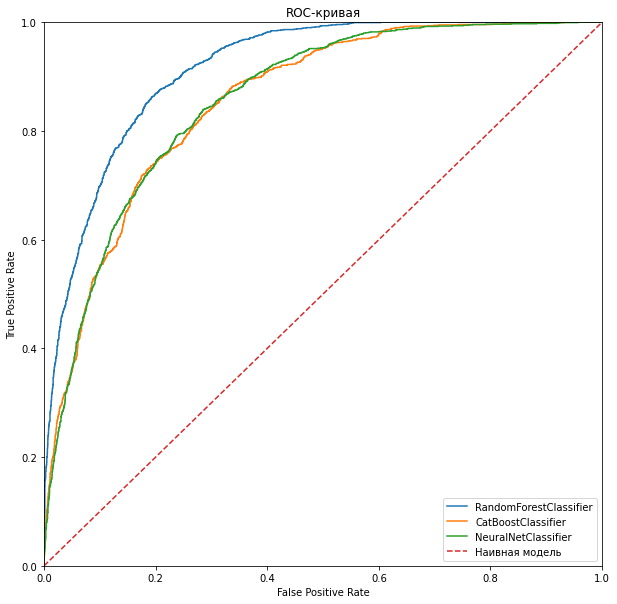

In [78]:
roc_auc_diagr(model_dict)

Создаем таблицу результатов:

In [79]:
# собираем таблицу
df_best_model = pd.DataFrame({'model' : ['RandomForestClassifier', 'CatBoostClassifier', 'NeuralNetClassifier'],
                              'roc_auc' : [roc_auc_rfc, roc_auc_cb, roc_auc_nn],
                              'best_model' : [best_model_rfc, best_model_cb, model_nn],
                             })
df_best_model[['model', 'roc_auc']]                # выводим таблицу

,model,roc_auc
0,RandomForestClassifier,0.838142
1,CatBoostClassifier,0.836296
2,NeuralNetClassifier,0.834454


Выделяем из таблицы модель с наибольшим ROC-AUC:

In [80]:
best_model_row = df_best_model.loc[df_best_model['roc_auc'] == df_best_model['roc_auc'].max()]   # строка с наибольшим ROC-AUC
best_model = best_model_row.iloc[0, 2]                                                           # модель с наибольшим ROC-AUC
best_model_name = best_model_row.iloc[0, 0]                                                      # название модели
best_model_params = best_model_row.iloc[0, 2].best_params_                                       # параметры модели

In [81]:
print('Лучшая модель: {}'.format(best_model_name))
print('Параметры лучшей модели: {}'.format(best_model_params))

Лучшая модель: RandomForestClassifier
Параметры лучшей модели: {'min_samples_leaf': 8, 'max_depth': 11, 'n_estimators': 110, 'criterion': 'entropy'}


**Вывод:**  
Рассмотрены три модели: RandomForestClassifier, CatBoostClassifier, NeuralNetClassifier.  
Наибольшее значение метрики ROC-AUC на кросс-валидации имеет модель RandomForestClassifier.  
ROC_AUC лучшей модели на кросс-валидации - ROC_AUC: 0.838.  
 
Параметры лучшей модели:  
 - min_samples_leaf': 8;
 - max_depth: 11;
 - n_estimators: 110;
 - criterion: entropy.

## Проверка на тестовой выборке
<a id="section_4"></a>

**Расчёт метрик лучшей модели на тестовой выборке**

Выбираем форму тестовой выборки в зависимости от типа лучшей модели:

In [82]:
if best_model_name == 'CatBoostClassifier':
    X_train_final = X_train
    X_test_final = X_test
    y_test_final = y_test
elif best_model_name == 'RandomForestClassifier':
    X_train_final = X_train_rfc
    X_test_final = X_test_rfc
    y_test_final = y_test
else:
    X_train_final = X_train_nn
    X_test_final = X_test_nn
    y_test_final = y_test_nn

Рассчитываем метрику ROC-AUC для тестовой выборки:

In [83]:
y_pred_proba = best_model.predict_proba(X_test_final)[:, 1]
auc_roc = roc_auc_score(y_test_final, y_pred_proba)
print('ROC-AUC на тестовой выборке:', round(auc_roc, 2))

ROC-AUC на тестовой выборке: 0.85


Рассчитываем метрики Recall, F1 и Accuracy:

In [84]:
y_pred = best_model.predict(X_test_final)
recall = recall_score(y_test_final, y_pred)
f1 = f1_score(y_test_final, y_pred)
accuracy = accuracy_score(y_test_final, y_pred)
print('Recall: {:.3f}'.format(recall))
print('F1: {:.3f}'.format(f1))
print('Accuracy: {:.3f}'.format(accuracy))

Recall: 0.792
F1: 0.647
Accuracy: 0.770


**Матрица ошибок**

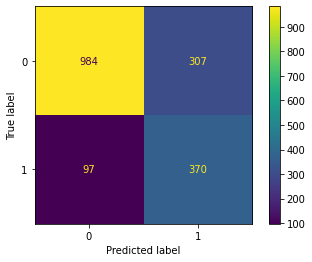

In [85]:
cm = confusion_matrix(y_test_final, y_pred)                                           # рассчитываем матрицу ошибок
disp = ConfusionMatrixDisplay(confusion_matrix=cm)                              
disp.plot()                                                                     # визуализируем матрицу ошибок
plt.show()

**Взаимосвязь полноты и точности**

In [86]:
y_score = best_model.predict_proba(X_test_final)[:,1]

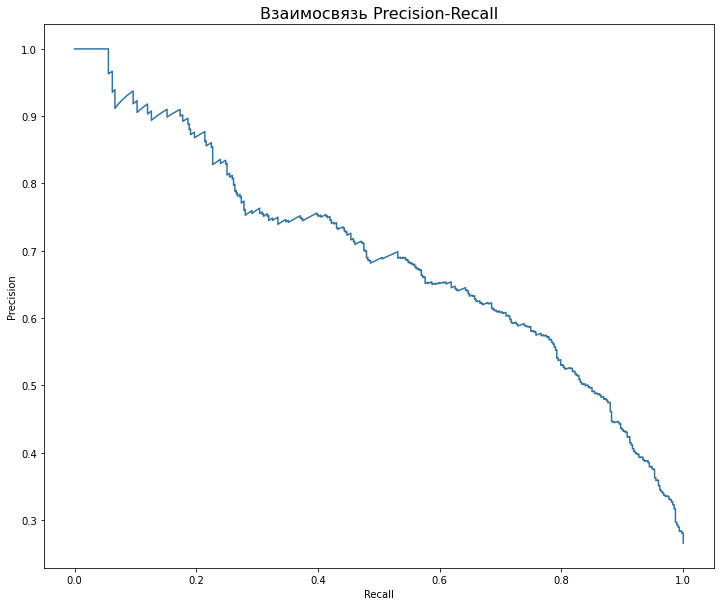

In [87]:
precision, recall, thresholds = precision_recall_curve(y_test_final, y_score)

fig = plt.figure(figsize=(12, 10))
plt.plot(recall, precision, color='#3174a1')

plt.title('Взаимосвязь Precision-Recall', fontsize=16)
plt.ylabel('Precision')
plt.xlabel('Recall')

plt.show() 

**Важность основных факторов**

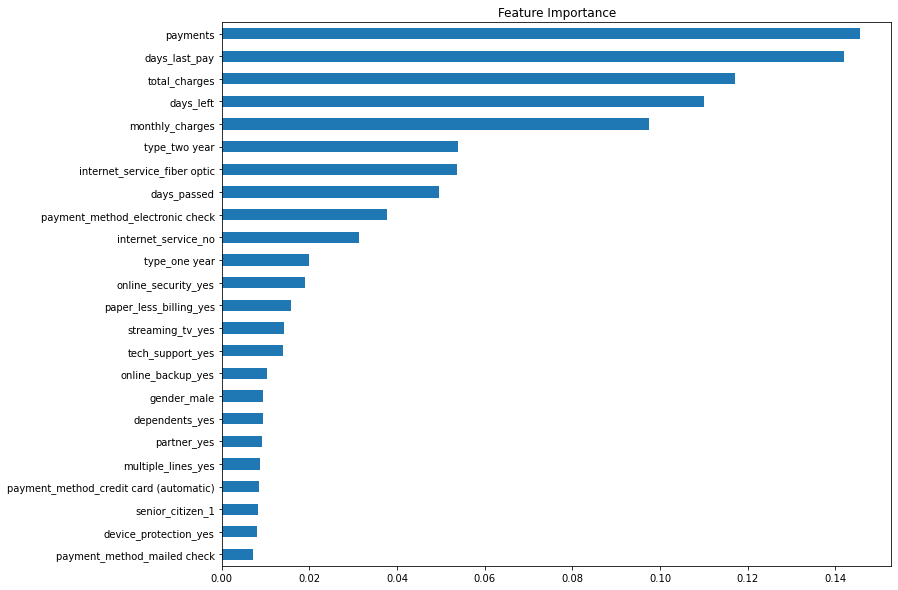

In [88]:
importance = best_model.best_estimator_.feature_importances_          # получаем значения важности признаков
# создаем серию со значениями важности признаков
importance_features = pd.Series(importance, index=X_train_final.columns).sort_values(ascending=True)
plt.figure(figsize=(12,10))                                           # задаем размер окна диаграммы
importance_features.plot(kind='barh',title = 'Feature Importance')    # визуализируем диаграмму
plt.show()

Строим график зависимости количества отказов от количества выплат:

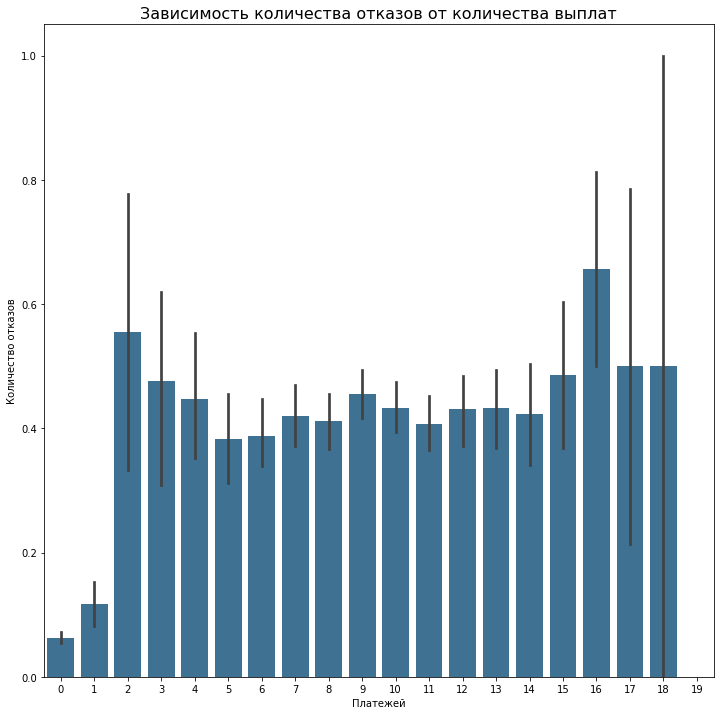

In [93]:
fig = plt.figure(figsize=(12,12))
ax = sns.barplot(x='payments',
                 y='go_out',
                 data=df,
                 color='#3174a1'
            )
plt.title('Зависимость количества отказов от количества выплат', fontsize=16)
plt.ylabel('Количество отказов')
plt.xlabel('Платежей')
plt.xticks(rotation=0)
plt.show()

**Вывод:**  
Метрики лучшей модели на тестовой выборке:
 - ROC-AUC: 0.85;
 - Recall: 0.792;
 - F1: 0.647;
 - Accuracy: 0.770.  
 
Значение ROC-AUC удовлетворяет требованию заказчика - не менее 0,85.  
 
Для заказчика важно выявлять положительный класс, т.е. важной метрикой является Recall - она превышает 0.8. Метрики, учитывающие качество определения обоих класов относительно невелики, что говорит о более высоком качестве модели в определении положительного класса, нежели отрицательного. Это же следует из матрицы ошибок.  
Одним из важнейших признаков для данной модели является количество платежей. В течение первых двух платежных периодов абоненты отписываются от сервиса редко. Резкий рост отписок происходит на третий платежный период.

## Общий вывод
<a id="section_5"></a>

**Анализ данных**  

1. Анализ исходных данных.  
- df_contract:  
В датафрейме 7043 строк. Присутствуют пропуски в данных по дате окончания договора (73%) и в данных по общим расходам (0,15%).  
В датафрейме 4 уникальных даты окончания договора.  
Дубликаты по идентификационному номеру абонента отсутствуют.  
Наибольшим спросом пользуется подписка на месяц.    
Чаще электронный расчётный лист используется абонентами, имеющими подписку на месяц.  
Самый популярный метод расчёта - Electronic check, в основном, за счет абонентов, имеющих подписку на месяц.  
Аномальные значения по ежемесячным и общим расходам отсутствуют.  

- df_personal:  
В датафрейме 7043 строк.  
Пропущенных значений нет.  
Все признаки, кроме идентификатора абонента - бинарные.  
В выборке не дисбаланса по признаку пола (gender) и наличия супруга или супруги (partner).  
Количество пенсионеров в 6 раз меньше, чем не пенсионеров.  
Количество абонентов с детьми в 2,5 меньше, чем бездетных.  

- df_internet:  
В датафрейме 5517 строк.  
Пропущенных значений нет.  
Все признаки, кроме идентификатора абонента - бинарные.  

- df_phone:  
В датафрейме 6361 строк.  
Пропущенных значений нет.  
Признак multiple_lines - бинарный.  


2. Анализ объединенной таблицы.   
В датафрейме 7032 строк. Пропущенные значения отсутствуют.  
В датафрейм добавлены следующие признаки:
- payments - количество платежей;
- days_passed - количество дней, которое действует или действовал договор;
- days_left - количество дней до следующего платежа;
- days_last_pay - количество дней, прошедших с даты последнего платежа.

Анализ признаков:
- type:  
Чем длительней срок подписки, тем меньше отписок.

- paper_less_billing:  
Чаще электронный расчётный лист используется абонентами, имеющими подписку на месяц.  
От подписки чаще отказываются те, кто пользуются электронным расчётным листом.

- payment_method:  
Самый популярный метод расчёта - Electronic check, в основном, за счет абонентов, имеющих подписку на месяц. Семейные абоненты предпочитают годовую или двухлетнюю подписку.    
От подписки чаще отказываются те, кто пользуются методом оплаты Electronic check.

- gender:  
Как мужчины, так и женщины наиболее часто пользуются подпиской на месяц.  
Так же они в равной степени отказываются от подписки.

- senior_citizen:  
Среди пользователей всех типов подписок большинство - не пенсионеры.  
Пенсионеры реже отказываются от подписки.

- partner:  
Среди пользователей, имеющий месячную подписку, - холостые. Большинство абонентов, имеющий годовую или двухгодичную подписку, - семейные.  
Находящиеся в браке абоненты реже отказываются от подписки.

- dependents:  
Наибольшая группа абонентов - бездетные абоненты с подпиской на месяц.  
Доля отказывающихся от подписки выше у бездетных абонентов.

- internet_service:  
Количество абонентов с годовой и двухлетней подпиской равномерно распределены по типу подключения - около 500 на каждый тип. Абоненты с месячной подпиской предпочитают тип подключения Fiber optic. - около 2000.  
Большинство отказов от подписки - у абонентов с подключением Fiber optic.

- online_security:  
Абоненты всех трех типов подписки чаще не пользуются блокировкой опасных сайтов. Особенно этим злоупотребляют абоненты с месячной подпиской - свыше 3000 абонентов.  
Доля отказов от подписки выше у пользователей, которые не пользуются блокировкой опасных сайтов.

- online_backup:  
Количество абонентов с годовой и двухлетней подпиской в равной степени как пользуются, так и не пользуются резервным копированием. Абоненты с месячной подпиской предпочитают не использовать резервное копирование.  
Доли отказов от подписки у абонентов, использующих резервное копирование и не использующих, сопоставимы.

- device_protection:  
Количество абонентов с годовой и двухлетней подпиской в равной степени как пользуются, так и не пользуются антивирусом. Абоненты с месячной подпиской предпочитают не использовать антивирус.  
Доли отказов от подписки у абонентов, использующих антивирус и не использующих, сопоставимы.

- tech_support:  
Количество абонентов с годовой и двухлетней подпиской в равной степени как пользуются, так и не пользуются выделенной линией техподдержки. Абоненты с месячной подпиской предпочитают не использовать выделенную линиею техподдержки.  
Доля отказов от подписки выше у пользователей, которые пользуются выделенной линией техподдержки.

- streaming_tv:  
Количество абонентов с годовой и двухлетней подпиской в равной степени как пользуются, так и не пользуются стриминговым телевидением. Абоненты с месячной подпиской предпочитают не пользоваться стриминговым телевидением.  
Доля отказов от подписки выше у пользователей, которые пользуются стриминговым телевидением.

- streaming_movies:  
Количество абонентов с годовой и двухлетней подпиской в равной степени как пользуются, так и не пользуются каталогом фильмов. Абоненты с месячной подпиской предпочитают не пользоваться каталогом фильмов.  
Доля отказов от подписки выше у пользователей, которые пользуются каталогом фильмов.

- multiple_lines:  
Количество абонентов с годовой и двухлетней подпиской в равной степени как пользуются, так и не пользуются подключением телефона к нескольким линиям. Абоненты с месячной подпиской предпочитают не пользоваться подключеним телефона к нескольким линиям.  
Доля отказов от подписки выше у пользователей, которые пользуются подключеним телефона к нескольким линиям.

- days_passed (пользования сервисом):  
Распределение длительности пользования сервисом имеет вид нормального распределения со средним 297.8 дней.  

Для абонентов с месячной подпиской есть выбросы в большую сторону значений общих расходов. При этом для месячных расходов выбросов нет. Из этого можно сделать вывод, что выбросы по общим расходом относятся к абонентам, пользующимися сервисом длительное время. Эти значения не являются аномальными.  

Высокая степень корреляции наблюдается у признаков streaming_tv и streaming_movies - 0,74. Один из них необходимо исключить из исследования. Поскольку у streaming_movies степень корреляции с остальными категориальными признаками выше, нежели у streaming_tv, исключаем его.  


3. Подготовка данных.  

Выборка разделена на обучающую и тестовую.  
Для модели RandomForestClassifier категориальные значения закодированы, числовые - отмасштабированы (OHE). Выборки имеют следующие наименования:  
 - X_train_rfc;
 - y_train;
 - X_test_rfc;
 - y_test.  
 
Для модели NeuralNetClassifier категориальные значения закодированы, числовые - отмасштабированы (OHE). Данные переведены в тензоры. Выборки имеют следующие наименования:  
 - X_train_nn;
 - y_train_nn;
 - X_test_nn;
 - y_test_nn.
 
Поскольку для модели CatBoostClassifier не требуется масштабирование и кодирование, для нее будут использоваться исходные обучающая и тестовая выборки:  
 - X_train;
 - y_train;
 - X_test;
 - y_test.  
 
В обучающей выборке присутствует дисбаланс классов. Доля положительного класса - 0,27.



**Обучение моделей**  

Рассмотрены три модели: RandomForestClassifier, CatBoostClassifier, NeuralNetClassifier.  
Наибольшее значение метрики ROC-AUC на кросс-валидации имеет модель RandomForestClassifier.  
ROC_AUC лучшей модели на кросс-валидации - ROC_AUC: 0.838.  
 
Параметры лучшей модели:  
 - min_samples_leaf': 8;
 - max_depth: 11;
 - n_estimators: 110;
 - criterion: entropy.
 
 
**Проверка на тестовой выборке**  

Метрики лучшей модели на тестовой выборке:
 - ROC-AUC: 0.85;
 - Recall: 0.792;
 - F1: 0.647;
 - Accuracy: 0.770.  
 
Значение ROC-AUC удовлетворяет требованию заказчика - не менее 0,85.  
 
Для заказчика важно выявлять положительный класс, т.е. важной метрикой является Recall - она превышает 0.8. Метрики, учитывающие качество определения обоих класов относительно невелики, что говорит о более высоком качестве модели в определении положительного класса, нежели отрицательного. Это же следует из матрицы ошибок.  
Одним из важнейших признаков для данной модели является количество платежей. В течение первых двух платежных периодов абоненты отписываются от сервиса редко. Резкий рост отписок происходит на третий платежный период.


**Рекомендации**  
Признак нахождения абонента в браке не определен моделью как имеющим высокую важность. Однако он в той или иной степени является определяющим для других признаков, таких как наличие детей, является ли абонент пенсионером и т.д. Согласно анализу данных семейные люди более тяготеют к стабильности, предпочитают оформлять длительные подписки и реже отписываются. А тип подписки - один из важнейших для модели.  
Поэтому рекомендуется отдать приоритет удовлетворению потребностей именно семейных абонентов, в особенности что касается стримиговых сервисов и интернет-безопасности.